# Proyecto Final - Tomás Mir Mercere

Profundizare sobre el Proyecto II sobre el dataset de Properati, por lo que al Final del Proyecto II profundizare sobre el objetivo del Proyecto Final.

Link Proyecto II Github: https://github.com/tomimir/test47/blob/main/Proyecto%20II%20Tomas%20Mir%20Mercere.ipynb

Link Proyecto Final Github: https://github.com/tomimir/test47/blob/main/Proyecto%20Final%20Tomas%20Mir%20Mercere.ipynb

## Proyecto II: Ingeniería de features, Modelos avanzados e Interpretación de modelos 

En este Segundo Proyecto estaremos aplicando la transformación de datos y entrenamiento de Modelos Avanzados para desarrollar con mayor profundidad tu modelo de Machine Learning.

Volveremos a utilziar el Data set del Primer Sprint para aprovechar todo el análisis Exploratorio de Datos realizado y enfocarnos en profundizar sobre la Optimización y Profundización de los Modelos.

**Parte A: Transformación de Datos**

Empezaré por importar todas las librerías que utilizaré en una primera instancia.

In [449]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

Descargo el Data set para poder hacer el Preprocesamiento.

In [450]:
data= pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
data = data.rename(columns={'l2': 'Zona', 'l1': 'País','l3':'Distrito'})
## Cambio el nombre de las Columnas para facilidad de identificación.
data.count()

start_date         146660
end_date           146660
created_on         146660
lat                136735
lon                136701
País               146660
Zona               146660
Distrito           146660
rooms              146660
bedrooms           146660
bathrooms          140703
surface_total      126133
surface_covered    125046
price              146660
currency           146660
title              146660
description        146660
property_type      146660
operation_type     146660
dtype: int64

In [451]:
data.property_type.nunique()
data['property_type'].value_counts()

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64

In [452]:
data_ml=data.copy()

Elimino las columnas de Latitud y Longitud dado que dada la experiencia del Proyecto Anterior no aportan información significante al análisis.

In [453]:
data_ml=data_ml.drop(['lat','lon'],axis=1)
data_ml.count()

start_date         146660
end_date           146660
created_on         146660
País               146660
Zona               146660
Distrito           146660
rooms              146660
bedrooms           146660
bathrooms          140703
surface_total      126133
surface_covered    125046
price              146660
currency           146660
title              146660
description        146660
property_type      146660
operation_type     146660
dtype: int64

Empezaré con el tratamiento de outliers para identificarlos y utilizar aquellos datos que hagan maás óptimo mi modelo.

In [454]:
i=0
n=0
for i in range(len(data_ml)):
    if(data_ml['surface_covered'][i]>data_ml['surface_total'][i]):
        data_ml['surface_total'][i]=data_ml['surface_covered'][i]
        n+=1
    i+=1
print(n,i)

<ipython-input-454-6c406ff1ddc9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['surface_total'][i]=data_ml['surface_covered'][i]


1432 146660


<AxesSubplot:xlabel='surface_total', ylabel='surface_covered'>

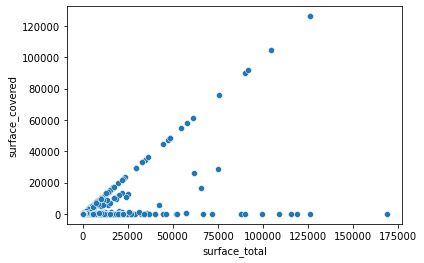

In [455]:
sns.scatterplot(x='surface_total',y='surface_covered',data=data_ml)

Verifico que hay datos inconsistentes en donde la superficie total es menor a la superficie cubierta, es por este motivo que decido reemplazar dichos datos igualando la superficie total a la superficie cubierta.

**Preprocesamiento de datos**

Voy a analizar los datos y proseguiré a ir eliminando los outliers.

In [456]:
data_ml.isnull().sum().sum()

48098

In [457]:
data_ml.isnull().sum()

start_date             0
end_date               0
created_on             0
País                   0
Zona                   0
Distrito               0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

Analizaré los outliers de las distintas variables, que lo podremos visualizar con los gráficos de Caja para identificar en cada variable los outliers.

**Baños**

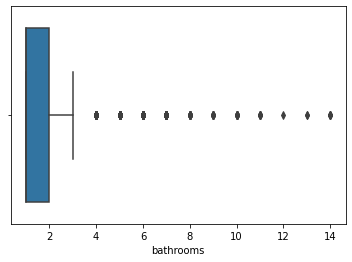

In [458]:
sns.boxplot(x=data_ml['bathrooms'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar que a partir de 4, empezaría 3 empezarían a aparecer los outliers. Proseguiré a hacer un filtro para ver como se visualiza el gráfico.

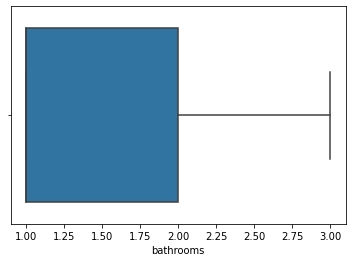

In [459]:
baños=data_ml['bathrooms']<4
sns.boxplot(x=data_ml[baños]['bathrooms'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Analizaré el rango intercuartílico entre el 2,5% y el 97,5%. Para luego analizar la lógica y en caso de ser lógico proseguiré a elminar los outliers.

In [460]:
data_ml['bathrooms'].quantile(0.975)

4.0

In [461]:
data_ml['bathrooms'].quantile(0.0275)

1.0

Me parece que una propiedad grande, podría llegar a tener 4 baños según la investigación que hice, por lo que eliminaré aquellas casas que tengan más de 5 baños y aquellas que no tengan baños dado que no debiera existir.

In [462]:
Filtro_1=(data_ml['bathrooms']>5)
index_filtro_1=data_ml[Filtro_1].index
data_ml=data_ml.drop(index=index_filtro_1)
data_ml.shape

(146181, 17)

In [463]:
Filtro_12=(data_ml['bathrooms']<1) 
index_filtro_12=data_ml[Filtro_12].index
data_ml=data_ml.drop(index=index_filtro_12)
data_ml.shape #Podemos notar que no eliminó ningún dato, por lo que es lógico dado que no existe una propiedad sin baños.

(146181, 17)

**Superficie Cubierta**

Proseguiré con el mismo análisis realizado para la variable baños e identificaré aquellos outliers para eliminarlos.

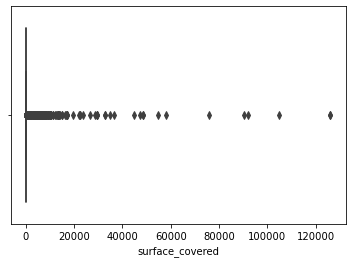

In [464]:
sns.boxplot(x=data_ml['surface_covered'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

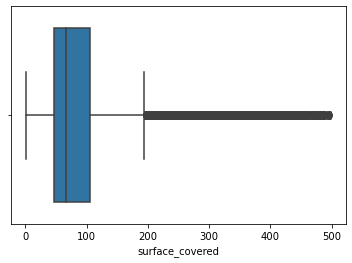

In [465]:
sup_cov=data_ml['surface_covered']<500
sns.boxplot(x=data_ml[sup_cov]['surface_covered'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar que el filtro de los 500 m2 no fue suficiente y sigue habiendo outliers, según el gráfico.

Analizaré el rango intercuartílico.

In [466]:
data_ml['surface_covered'].quantile(0.975)

302.0

In [467]:
data_ml['surface_covered'].quantile(0.0275)

30.0

Es muy dificil encontrar una superficie cubierta mayor a 300 m2. Es por este motivo que me parece lógico el número del intercuartílico del 97,5% y optaré por eliminar los valores mayores a esos.
Por otro lado, según investigué también es dificil de encontrar una propiedad menor a 30m2 por lo que eliminaré los valores menores a 30 m2 de superficie cubierta.

In [468]:
Filtro_2=(data_ml['surface_covered']>302)
index_filtro_2=data_ml[Filtro_2].index
data_ml=data_ml.drop(index=index_filtro_2)
data_ml.shape

(143076, 17)

In [469]:
Filtro_22=(data_ml['surface_covered']<30)
index_filtro_22=data_ml[Filtro_22].index
data_ml=data_ml.drop(index=index_filtro_22)
data_ml.shape

(140217, 17)

**Superficie Total**

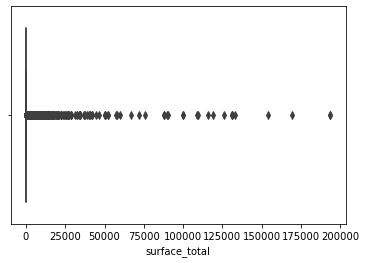

In [470]:
sns.boxplot(x=data_ml['surface_total'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

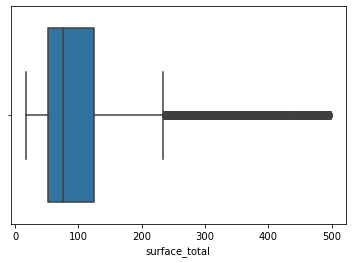

In [471]:
sup_tot=data_ml['surface_total']<500
sns.boxplot(x=data_ml[sup_tot]['surface_total'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [472]:
data_ml['surface_total'].quantile(0.975)

671.0

In [473]:
data_ml['surface_total'].quantile(0.0275)

35.0

Si bien es verdad que una propiedad de mas de 600 m2 es dificil de encontrar, es casi imposible encontrarla en la Capital Federal por las dimensiones de la misma, por lo que me aseguraré, de que no se encuentre ninguna propiedad de más de 600m2.
Tambíen según lo analizado por una Ley en CABA, Argentina una propiedad no puede tener menos de 30m2, por lo que me parece lógico eliminar todas aquellas menores a 30m2.

In [474]:
Filtro_3=(data_ml['surface_total']>671)
index_filtro_3=data_ml[Filtro_3].index
data_ml=data_ml.drop(index=index_filtro_3)
data_ml.shape

(137222, 17)

In [475]:
Filtro_3222=(data_ml['surface_total']>600)&(data_ml['Zona']=="Capital Federal")
index_filtro_3222=data_ml[Filtro_3222].index
data_ml=data_ml.drop(index=index_filtro_3222)
data_ml.shape

(137217, 17)

In [476]:
Filtro_32=(data_ml['surface_total']<30) 
index_filtro_32=data_ml[Filtro_32].index
data_ml=data_ml.drop(index=index_filtro_32)
data_ml.shape

(137191, 17)

Analizaré dentro de PH, Departamentos y Casas las superficies de cada uno. Dado que tienen distintas dimensiones.

In [477]:
PH= (data_ml['property_type']=="PH")&(data_ml['surface_total']>300) #Todos lOS PH superiores a 300m2 son eliminados dado que he investigado no suelen tener esa superficie.
data_ml[PH].count()

start_date         448
end_date           448
created_on         448
País               448
Zona               448
Distrito           448
rooms              448
bedrooms           448
bathrooms          444
surface_total      448
surface_covered    447
price              448
currency           448
title              448
description        448
property_type      448
operation_type     448
dtype: int64

In [478]:
index_filtro_321=data_ml[PH].index
data_ml=data_ml.drop(index=index_filtro_321)
data_ml.shape

(136743, 17)

In [479]:
Casa= (data_ml['property_type']=="Casa")&(data_ml['Zona']=="Capital Federal")&(data_ml['surface_total']<50) #Todas las casas superiores a 50m2 son eliminados dado que he investigado no suelen tener esa superficie.
data_ml[Casa].count()

start_date         13
end_date           13
created_on         13
País               13
Zona               13
Distrito           13
rooms              13
bedrooms           13
bathrooms          13
surface_total      13
surface_covered    12
price              13
currency           13
title              13
description        13
property_type      13
operation_type     13
dtype: int64

In [480]:
index_filtro_322=data_ml[Casa].index
data_ml=data_ml.drop(index=index_filtro_322)
data_ml.shape

(136730, 17)

**Precio**

Haré el mismo análisis realizados para las otras variables.

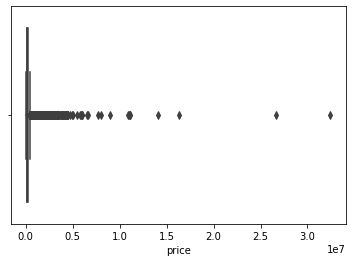

In [481]:
sns.boxplot(x=data_ml['price'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

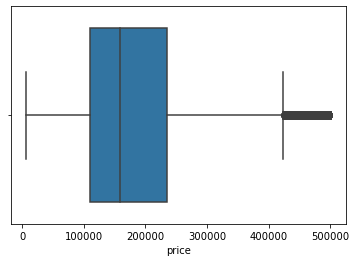

In [482]:
price=data_ml['price']<500000
sns.boxplot(x=data_ml[price]['price'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [483]:
data_ml['price'].quantile(0.975)

780000.0

In [484]:
data_ml['price'].quantile(0.0275)

60000.0

In [485]:
Filtro_4=(data_ml['price']>5000000) 
index_filtro_4=data_ml[Filtro_4].index
data_ml=data_ml.drop(index=index_filtro_4)
data_ml.shape

(136711, 17)

Si bien el rango intercuartílico me propone un precio de USD 790.000, entiendo que en el mercado hay propiedades de hasta USD 5.000.000, por lo que optaré por ese número.
Por otro lado, eliminaré aquellas propiedades con un valor menor que los USD 61.000.

In [486]:
Filtro_42=(data_ml['price']<61000)
index_filtro_42=data_ml[Filtro_42].index
data_ml=data_ml.drop(index=index_filtro_42)
data_ml.shape

(132642, 17)

**Roooms**

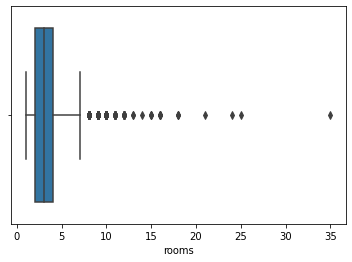

In [487]:
sns.boxplot(x=data_ml['rooms'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

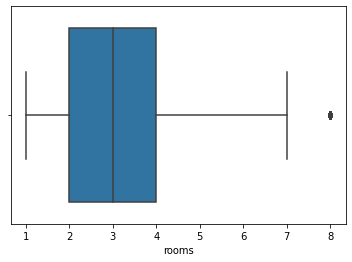

In [488]:
rooms=data_ml['rooms']<9
sns.boxplot(x=data_ml[rooms]['rooms'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [489]:
data_ml['rooms'].quantile(0.975)

6.0

In [490]:
data_ml['rooms'].quantile(0.0275)

1.0

In [491]:
Filtro_5=(data_ml['rooms']>8) # Si bien el cuartil 97,5% me dice que el valor es USD 750.000, entiendo que en el Mercado hay valores de hasta USD 5.000.000
index_filtro_5=data_ml[Filtro_5].index
data_ml=data_ml.drop(index=index_filtro_5)
data_ml.shape

(132398, 17)

In [492]:
Filtro_52=(data_ml['rooms']<1)
index_filtro_52=data_ml[Filtro_52].index
data_ml=data_ml.drop(index=index_filtro_52)
data_ml.shape

(132398, 17)

Observaré las distintas variables para corroborar que sea lógica la distribución es decir a mayor superficie, mayor sea el precio. También dependerá de la zona por lo que no debería ser tán lineal dado que hay otros factores que estan involucrados.

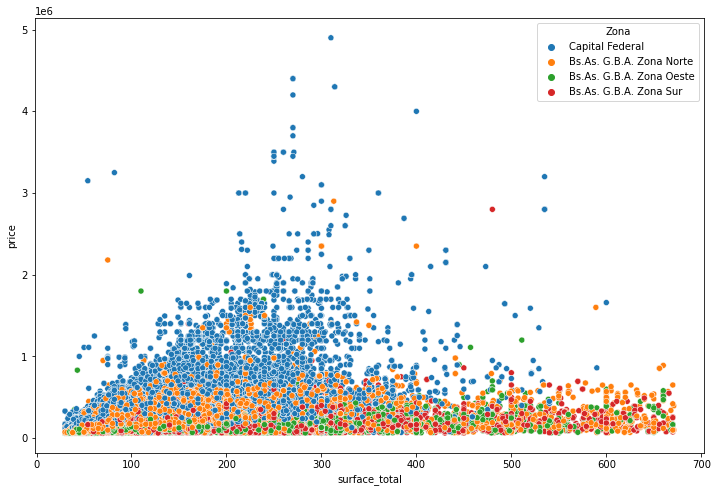

In [493]:
plt.figure(figsize= (12,8))
sns.scatterplot(data=data_ml,x='surface_total',y='price',hue='Zona')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

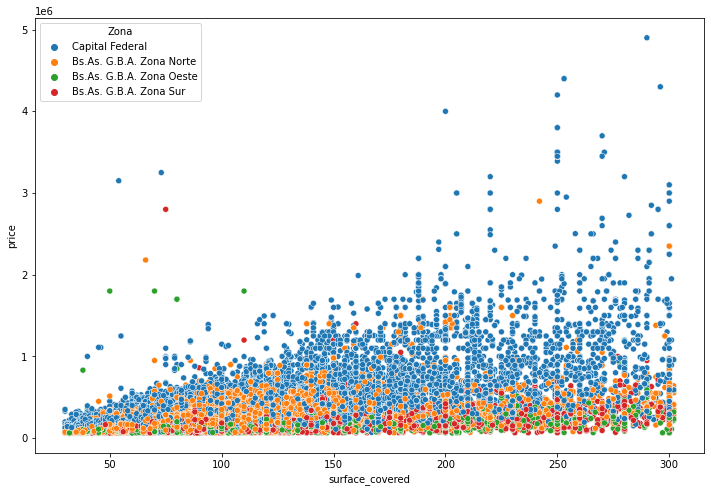

In [494]:
plt.figure(figsize= (12,8))
sns.scatterplot(data=data_ml,x='surface_covered',y='price',hue='Zona')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar como se da ese incremento por Zona a medida que aumenta la superficie cubierta y como aumenta el valor.

Una vez relizada la limpieza del Data set de los datos **Outliers** empezaré por analizar los **datos faltantes** del Data Set y adoptaré por el modelo de imputación más óptimo y que mejor se ajuste a los datos.

In [495]:
data_ml.property_type.nunique()
data_ml['property_type'].value_counts()

Departamento       101007
Casa                16259
PH                  12932
Lote                  804
Oficina               541
Local comercial       283
Depósito              254
Otro                  230
Casa de campo          82
Cochera                 6
Name: property_type, dtype: int64

Como pudimos visualizar hay 3 variables que contienen datos faltantes, **"Bathrooms"**, **"Surface_total"** y **"Surface_covered"**.

In [496]:
data_media=data_ml.copy()

En esta instancia para los datos faltantes vamos a reemplazar dichos datos de la Superficie, por la superficie promedio que tiene su mismo tipo de propiedad. Voy a realizar una imputación de datos utilizando el promedio de cada tipo de Propiedad.

In [497]:
data_depto=data_media[data_media.property_type =='Departamento']

In [498]:
data_depto['surface_total'].fillna(data_depto.surface_total.mean(),inplace=True)

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [499]:
data_depto.isnull().sum()

start_date             0
end_date               0
created_on             0
País                   0
Zona                   0
Distrito               0
rooms                  0
bedrooms               0
bathrooms           2509
surface_total          0
surface_covered    13008
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

In [500]:
data_depto['surface_covered'].fillna(data_depto.surface_covered.mean(),inplace=True)

In [501]:
data_depto.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          2509
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [502]:
data_depto['bathrooms'].fillna(data_depto.bathrooms.mean(),inplace=True)

In [503]:
data_depto.isnull().sum()

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [504]:
data_media[data_media.property_type =='Departamento']=data_depto
data_media['bathrooms']=round(data_media['bathrooms'])

In [505]:
data_media.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          2432
surface_total      6247
surface_covered    6575
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

Así como lo hice con **Departamentos** lo haré con todos los tipos de propiedad.

In [506]:
data_casa=data_media[data_media.property_type =='Casa']

In [507]:
data_casa['surface_covered'].fillna(data_casa.surface_covered.mean(),inplace=True)
data_casa['surface_total'].fillna(data_casa.surface_total.mean(),inplace=True)
data_casa['bathrooms'].fillna(data_casa.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Casa']=data_casa
data_media['bathrooms']=round(data_media['bathrooms'])

In [508]:
data_media.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          1235
surface_total      1540
surface_covered    1902
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

Una vez realizado voy analizando la cantidad de datos faltantes que van quedando.

In [509]:
data_lote=data_media[data_media.property_type =='Lote']

In [510]:
data_lote['surface_covered'].fillna(data_lote.surface_covered.mean(),inplace=True)
data_lote['surface_total'].fillna(data_lote.surface_total.mean(),inplace=True)
data_lote['bathrooms'].fillna(data_lote.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Lote']=data_lote
data_media['bathrooms']=round(data_media['bathrooms'])

In [511]:
data_media.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms           730
surface_total      1054
surface_covered    1115
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [512]:
data_ph=data_media[data_media.property_type =='PH']
data_ph['surface_covered'].fillna(data_ph.surface_covered.mean(),inplace=True)
data_ph['surface_total'].fillna(data_ph.surface_total.mean(),inplace=True)
data_ph['bathrooms'].fillna(data_ph.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='PH']=data_ph
data_media['bathrooms']=round(data_media['bathrooms'])

In [513]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          578
surface_total      948
surface_covered    973
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [514]:
data_of=data_media[data_media.property_type =='Oficina']
data_of['surface_covered'].fillna(data_of.surface_covered.mean(),inplace=True)
data_of['surface_total'].fillna(data_of.surface_total.mean(),inplace=True)
data_of['bathrooms'].fillna(data_of.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Oficina']=data_of
data_media['bathrooms']=round(data_media['bathrooms'])

In [515]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          499
surface_total      729
surface_covered    742
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [516]:
data_cam=data_media[data_media.property_type =='Casa de campo']
data_cam['surface_covered'].fillna(data_cam.surface_covered.mean(),inplace=True)
data_cam['surface_total'].fillna(data_cam.surface_total.mean(),inplace=True)
data_cam['bathrooms'].fillna(data_cam.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Casa de campo']=data_cam
data_media['bathrooms']=round(data_media['bathrooms'])

In [517]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          483
surface_total      665
surface_covered    678
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

Como podemos notar, no hubo diferencias en lo que es datos faltantes por lo que el tipo de Propiedad de Casa de Campo no posee datos faltantes.

In [518]:
data_ot=data_media[data_media.property_type =='Otro']
data_ot['surface_covered'].fillna(data_ot.surface_covered.mean(),inplace=True)
data_ot['surface_total'].fillna(data_ot.surface_total.mean(),inplace=True)
data_ot['bathrooms'].fillna(data_ot.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Otro']=data_ot
data_media['bathrooms']=round(data_media['bathrooms'])

In [519]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          373
surface_total      528
surface_covered    530
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [520]:
data_de=data_media[data_media.property_type =='Depósito']
data_de['surface_covered'].fillna(data_de.surface_covered.mean(),inplace=True)
data_de['surface_total'].fillna(data_de.surface_total.mean(),inplace=True)
data_de['bathrooms'].fillna(data_de.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Depósito']=data_de
data_media['bathrooms']=round(data_media['bathrooms'])

In [521]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          149
surface_total      275
surface_covered    277
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [522]:
data_co=data_media[data_media.property_type =='Cochera']
data_co['surface_covered'].fillna(data_co.surface_covered.mean(),inplace=True)
data_co['surface_total'].fillna(data_co.surface_total.mean(),inplace=True)
data_co['bathrooms'].fillna(data_co.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Cochera']=data_co
data_media['bathrooms']=round(data_media['bathrooms'])

In [523]:
data_media.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          149
surface_total      275
surface_covered    277
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [524]:
data_lo=data_media[data_media.property_type =='Local comercial']
data_lo['surface_covered'].fillna(data_lo.surface_covered.mean(),inplace=True)
data_lo['surface_total'].fillna(data_lo.surface_total.mean(),inplace=True)
data_lo['bathrooms'].fillna(data_lo.bathrooms.mean(),inplace=True)
data_media[data_media.property_type =='Local comercial']=data_lo
data_media['bathrooms']=round(data_media['bathrooms'])

In [525]:
data_media.isnull().sum()

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          6
surface_total      6
surface_covered    6
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [526]:
data_media.dropna(inplace=True) #Opto por eliminar los 6 datos que hacen referencia al tipo de "Cochera" dado que tanto la superficie cubierta como la superficie total tiene datos nulos.
data_media.isnull().sum()

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

Podemos notar como se reemplazaron todos los datos con las medias de cada tipo de propiedad.

He realizado la imputación de datos por la imputación a través de la media, proseguiré a hacerlo a través del método de la mediana.

In [527]:
data_mediana=data_ml.copy()

Realizaré el mismo análisis de la media pero esta vez bajo el metodo de imputación con la **Mediana**, por lo que lo haré por cada tipo de propiedad.

In [528]:
data_depto1=data_mediana[data_mediana.property_type =='Departamento']
data_depto1['surface_covered'].fillna(data_depto1.surface_covered.median(),inplace=True)
data_depto1['surface_total'].fillna(data_depto1.surface_total.median(),inplace=True)
data_depto1['bathrooms'].fillna(data_depto1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Departamento']=data_depto1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [529]:
data_mediana.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          2432
surface_total      6247
surface_covered    6575
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [530]:
data_casa1=data_mediana[data_mediana.property_type =='Casa']
data_casa1['surface_covered'].fillna(data_casa1.surface_covered.median(),inplace=True)
data_casa1['surface_total'].fillna(data_casa1.surface_total.median(),inplace=True)
data_casa1['bathrooms'].fillna(data_casa1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Casa']=data_casa1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [531]:
data_mediana.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          1235
surface_total      1540
surface_covered    1902
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [532]:
data_lote1=data_mediana[data_mediana.property_type =='Lote']
data_lote1['surface_covered'].fillna(data_lote1.surface_covered.median(),inplace=True)
data_lote1['surface_total'].fillna(data_lote1.surface_total.median(),inplace=True)
data_lote1['bathrooms'].fillna(data_lote1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Lote']=data_lote1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms           730
surface_total      1054
surface_covered    1115
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [533]:
data_ph1=data_mediana[data_mediana.property_type =='PH']
data_ph1['surface_covered'].fillna(data_ph1.surface_covered.median(),inplace=True)
data_ph1['surface_total'].fillna(data_ph1.surface_total.median(),inplace=True)
data_ph1['bathrooms'].fillna(data_ph1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='PH']=data_ph1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          578
surface_total      948
surface_covered    973
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [534]:
data_of1=data_mediana[data_mediana.property_type =='Oficina']
data_of1['surface_covered'].fillna(data_of1.surface_covered.median(),inplace=True)
data_of1['surface_total'].fillna(data_of1.surface_total.median(),inplace=True)
data_of1['bathrooms'].fillna(data_of1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Oficina']=data_of1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          499
surface_total      729
surface_covered    742
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [535]:
data_ca1=data_mediana[data_mediana.property_type =='Casa de campo']
data_ca1['surface_covered'].fillna(data_ca1.surface_covered.median(),inplace=True)
data_ca1['surface_total'].fillna(data_ca1.surface_total.median(),inplace=True)
data_ca1['bathrooms'].fillna(data_ca1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Casa de campo']=data_ca1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          483
surface_total      665
surface_covered    678
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [536]:
data_ot1=data_mediana[data_mediana.property_type =='Otro']
data_ot1['surface_covered'].fillna(data_ot1.surface_covered.median(),inplace=True)
data_ot1['surface_total'].fillna(data_ot1.surface_total.median(),inplace=True)
data_ot1['bathrooms'].fillna(data_ot1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Otro']=data_ot1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          373
surface_total      528
surface_covered    530
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [537]:
data_lo1=data_mediana[data_mediana.property_type =='Local comercial']
data_lo1['surface_covered'].fillna(data_lo1.surface_covered.median(),inplace=True)
data_lo1['surface_total'].fillna(data_lo1.surface_total.median(),inplace=True)
data_lo1['bathrooms'].fillna(data_lo1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Local comercial']=data_lo1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          230
surface_total      259
surface_covered    259
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [538]:
data_deposito1=data_mediana[data_mediana.property_type =='Depósito']
data_deposito1['surface_covered'].fillna(data_deposito1.surface_covered.median(),inplace=True)
data_deposito1['surface_total'].fillna(data_deposito1.surface_total.median(),inplace=True)
data_deposito1['bathrooms'].fillna(data_deposito1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Depósito']=data_deposito1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          6
surface_total      6
surface_covered    6
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [539]:
data_cochera1=data_mediana[data_mediana.property_type =='Cochera']
data_cochera1['surface_covered'].fillna(data_cochera1.surface_covered.median(),inplace=True)
data_cochera1['surface_total'].fillna(data_cochera1.surface_total.median(),inplace=True)
data_cochera1['bathrooms'].fillna(data_cochera1.bathrooms.median(),inplace=True)
data_mediana[data_mediana.property_type =='Cochera']=data_cochera1
data_mediana['bathrooms']=round(data_mediana['bathrooms'])
data_mediana.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          6
surface_total      6
surface_covered    6
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [540]:
data_mediana.dropna(inplace=True)
data_mediana.isnull().sum()

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

Podemos notar como se reemplazaron los datos según la **Mediana** de todos los tipos de propiedad.

Como último metodo de imputación, optaré por utilziar Vecinos Cernanos el modelo de KNN Imputer y luego poder comparar los datasets para optar por el mejor método.

In [541]:
data_KNN=data_ml.copy()

Haré el mismo analisis, imputando los datos según los tipos de propiedad para poder generar un modelo óptimo.

Como se que la superficie total esta directamente relacionada con la superficie cubierta, voy a utilizar ambas variables para que imputen los datos con respecto a la otra, según el tipo de propiedad.

In [542]:
data_d12=data_KNN[data_KNN.property_type =='Departamento']
X_0=data_d12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_0)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,140.00000,7.00000,7.00000,2.00000
1,59.00000,2.00000,1.00000,1.00000
2,44.00000,2.00000,1.00000,1.00000
3,84.00000,2.00000,1.00000,2.00000
4,50.00000,2.00000,1.00000,1.00000


In [543]:
data_d12.surface_covered=imp[[0]].values
data_d12.rooms=imp[[1]].values
data_d12.bedrooms=imp[[2]].values
data_d12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Departamento']=data_d12
data_KNN.head()
data_d12.shape

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(101007, 17)

In [544]:
data_d12=data_KNN[data_KNN.property_type =='Departamento']
X_0=data_d12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_0)
imp=pd.DataFrame(impute)
imp.head()
data_d12.surface_covered=imp[[0]].values
data_d12.rooms=imp[[1]].values
data_d12.bedrooms=imp[[2]].values
data_d12.bathrooms=imp[[3]].values
data_d12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Departamento']=data_d12
data_KNN.head()
data_d12.shape

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(101007, 17)

In [545]:
data_KNN.isnull().sum()

start_date            0
end_date              0
created_on            0
País                  0
Zona                  0
Distrito              0
rooms                 0
bedrooms              0
bathrooms          2432
surface_total      6247
surface_covered    6575
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [546]:
X0=data_d12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X0)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,2.00000,7.00000,7.00000
1,1.00000,1.00000,2.00000
2,1.00000,1.00000,2.00000
3,2.00000,1.00000,2.00000
4,1.00000,1.00000,2.00000


Como se que los cuartos estan directamente relacionada con la variable baños, voy a utilizar ambas variables para que imputen los datos con respecto a la otra, según el tipo de propiedad.

In [547]:
data_d12.bedrooms=imp[[1]].values
data_d12.bathrooms=imp[[0]].values
data_d12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Departamento']=data_d12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [548]:
data_c12=data_KNN[data_KNN.property_type =='Casa']
X_1=data_c12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_1)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,79.00000,3.00000,2.00000,2.00000
1,90.00000,3.00000,2.00000,1.00000
2,183.00000,6.00000,4.00000,3.00000
3,116.00000,3.00000,1.00000,2.00000
4,120.00000,3.00000,2.00000,1.00000


In [549]:
data_c12.surface_covered=imp[[0]].values
data_c12.rooms=imp[[1]].values
data_c12.bedrooms=imp[[2]].values
data_c12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Casa']=data_c12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [550]:
data_c12=data_KNN[data_KNN.property_type =='Casa']
X_1=data_c12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_1)
imp=pd.DataFrame(impute)
imp.head()
data_c12.surface_covered=imp[[0]].values
data_c12.rooms=imp[[1]].values
data_c12.bedrooms=imp[[2]].values
data_c12.bathrooms=imp[[3]].values
data_c12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Casa']=data_c12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [551]:
X1=data_c12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X1)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,2.00000,2.00000,3.00000
1,1.00000,2.00000,3.00000
2,3.00000,4.00000,6.00000
3,2.00000,1.00000,3.00000
4,1.00000,2.00000,3.00000


In [552]:
data_c12.bedrooms=imp[[1]].values
data_c12.bathrooms=imp[[0]].values
data_c12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Casa']=data_c12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [553]:
data_ph12=data_KNN[data_KNN.property_type =='PH']
X_2=data_ph12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_2)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,58.00000,2.00000,1.00000,2.00000
1,45.00000,2.00000,1.00000,1.00000
2,50.00000,2.00000,1.00000,1.00000
3,56.00000,2.00000,1.00000,1.00000
4,70.00000,2.00000,1.00000,1.00000


In [554]:
data_ph12.surface_covered=imp[[0]].values
data_ph12.rooms=imp[[1]].values
data_ph12.bedrooms=imp[[2]].values
data_ph12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='PH']=data_ph12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [555]:
data_ph12=data_KNN[data_KNN.property_type =='PH']
X_2=data_ph12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_2)
imp=pd.DataFrame(impute)
imp.head()
data_ph12.surface_covered=imp[[0]].values
data_ph12.rooms=imp[[1]].values
data_ph12.bedrooms=imp[[2]].values
data_ph12.bathrooms=imp[[3]].values
data_ph12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='PH']=data_ph12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [556]:
X2=data_ph12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X2)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,2.00000,1.00000,2.00000
1,1.00000,1.00000,2.00000
2,1.00000,1.00000,2.00000
3,1.00000,1.00000,2.00000
4,1.00000,1.00000,2.00000


In [557]:
data_ph12.bedrooms=imp[[1]].values
data_ph12.bathrooms=imp[[0]].values
data_ph12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='PH']=data_ph12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [558]:
data_l12=data_KNN[data_KNN.property_type =='Lote']
X_4=data_l12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_4)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,130.90000,4.00000,3.00000,2.00000
1,119.90000,4.00000,2.00000,2.00000
2,130.90000,4.00000,3.00000,2.00000
3,120.00000,2.00000,1.00000,2.00000
4,117.40000,1.00000,1.00000,1.40000


In [559]:
data_l12.surface_covered=imp[[0]].values
data_l12.rooms=imp[[1]].values
data_l12.bedrooms=imp[[2]].values
data_l12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Lote']=data_l12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [560]:
data_l12=data_KNN[data_KNN.property_type =='Lote']
X_4=data_l12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_4)
imp=pd.DataFrame(impute)
imp.head()
data_l12.surface_covered=imp[[0]].values
data_l12.rooms=imp[[1]].values
data_l12.bedrooms=imp[[2]].values
data_l12.bathrooms=imp[[3]].values
data_l12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Lote']=data_l12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [561]:
X4=data_l12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X4)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,2.00000,3.00000,4.00000
1,2.00000,2.00000,4.00000
2,2.00000,3.00000,4.00000
3,2.00000,1.00000,2.00000
4,1.40000,1.00000,1.00000


In [562]:
data_l12.bedrooms=imp[[1]].values
data_l12.bathrooms=imp[[0]].values
data_l12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Lote']=data_l12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [563]:
data_ca12=data_KNN[data_KNN.property_type =='Casa de campo']
X_5=data_ca12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_5)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,122.00000,3.00000,2.00000,1.00000
1,139.10000,4.00000,3.00000,2.00000
2,142.90000,4.00000,3.00000,4.00000
3,126.20000,4.00000,3.00000,1.90000
4,149.20000,4.00000,3.00000,5.00000


In [564]:
data_ca12.surface_covered=imp[[0]].values
data_ca12.rooms=imp[[1]].values
data_ca12.bedrooms=imp[[2]].values
data_ca12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Casa de campo']=data_ca12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [565]:
data_ca12=data_KNN[data_KNN.property_type =='Casa de campo']
X_5=data_ca12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_5)
imp=pd.DataFrame(impute)
imp.head()
data_ca12.surface_covered=imp[[0]].values
data_ca12.rooms=imp[[1]].values
data_ca12.bedrooms=imp[[2]].values
data_ca12.bathrooms=imp[[3]].values
data_ca12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Casa de campo']=data_ca12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [566]:
X5=data_ca12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X5)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,1.00000,2.00000,3.00000
1,2.00000,3.00000,4.00000
2,4.00000,3.00000,4.00000
3,1.90000,3.00000,4.00000
4,5.00000,3.00000,4.00000


In [567]:
data_ca12.bedrooms=imp[[1]].values
data_ca12.bathrooms=imp[[0]].values
data_ca12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Casa de campo']=data_ca12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [568]:
data_o12=data_KNN[data_KNN.property_type =='Otro']
X_6=data_o12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_6)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2,3
0,40.00000,2.00000,1.00000,1.00000
1,240.00000,6.00000,4.00000,2.00000
2,138.00000,4.00000,3.00000,3.00000
3,151.00000,4.00000,3.00000,2.00000
4,166.00000,5.00000,3.00000,3.00000


In [569]:
data_o12.surface_covered=imp[[0]].values
data_o12.rooms=imp[[1]].values
data_o12.bedrooms=imp[[2]].values
data_o12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Otro']=data_o12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [570]:
data_o12=data_KNN[data_KNN.property_type =='Otro']
X_6=data_o12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_6)
imp=pd.DataFrame(impute)
imp.head()
data_o12.surface_covered=imp[[0]].values
data_o12.rooms=imp[[1]].values
data_o12.bedrooms=imp[[2]].values
data_o12.bathrooms=imp[[3]].values
data_o12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Otro']=data_o12
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [571]:
X6=data_o12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X6)
imp=pd.DataFrame(impute)
imp.head()

,0,1,2
0,1.00000,1.00000,2.00000
1,2.00000,4.00000,6.00000
2,3.00000,3.00000,4.00000
3,2.00000,3.00000,4.00000
4,3.00000,3.00000,5.00000


In [572]:
data_o12.bedrooms=imp[[1]].values
data_o12.bathrooms=imp[[0]].values
data_o12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Otro']=data_o12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.head()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,start_date,end_date,created_on,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,Argentina,Capital Federal,Villa Crespo,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


In [573]:
data_KNN.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          452
surface_total      747
surface_covered    761
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [574]:
#data_co12=data_KNN[data_KNN.property_type =='Cochera']
#X_7=data_co12[['surface_covered','rooms','bedrooms','bathrooms']]
#imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
#impute=imputer.fit_transform(X_7)
#imp=pd.DataFrame(impute)
#imp.head()


In [575]:
#data_co12.surface_covered=imp[[0]].values
#data_co12.rooms=imp[[1]].values
#data_co12.bedrooms=imp[[2]].values
#data_co12.bathrooms=imp[[3]].values
#data_KNN[data_KNN.property_type =='Cochera']=data_co12
#data_KNN.head()

In [576]:
#X7=data_co12[['bathrooms','bedrooms','rooms']]
#imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
#impute=imputer.fit_transform(X7)
#imp=pd.DataFrame(impute)
#imp.head()

In [577]:
#data_co12.bedrooms=imp[[1]].values
#data_co12.bathrooms=imp[[0]].values
#data_co12.rooms=imp[[2]].values
#data_KNN[data_KNN.property_type =='Cochera']=data_co12
#data_KNN['bathrooms']=round(data_KNN['bathrooms'])
#data_KNN.head()

In [578]:
data_KNN.isnull().sum()

start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          452
surface_total      747
surface_covered    761
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [579]:
data_deposito12=data_KNN[data_KNN.property_type =='Depósito']
X_8=data_deposito12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_8)
imp=pd.DataFrame(impute)
imp.head()
data_deposito12.surface_covered=imp[[0]].values
data_deposito12.rooms=imp[[1]].values
data_deposito12.bedrooms=imp[[2]].values
data_deposito12.abthrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Depósito']=data_deposito12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-579-c83bdf40de81>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_deposito12.abthrooms=imp[[3]].values


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          452
surface_total      747
surface_covered    508
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [580]:
data_deposito12=data_KNN[data_KNN.property_type =='Depósito']
X_8=data_deposito12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_8)
imp=pd.DataFrame(impute)
imp.head()
data_deposito12.surface_covered=imp[[0]].values
data_deposito12.rooms=imp[[1]].values
data_deposito12.bedrooms=imp[[2]].values
data_deposito12.abthrooms=imp[[3]].values
data_deposito12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Depósito']=data_deposito12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-580-46ffe3b0a710>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_deposito12.abthrooms=imp[[3]].values


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          452
surface_total      494
surface_covered    508
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [581]:
X8=data_deposito12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X8)
imp=pd.DataFrame(impute)
imp.head()
data_deposito12.bedrooms=imp[[1]].values
data_deposito12.bathrooms=imp[[0]].values
data_deposito12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Depósito']=data_deposito12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms          228
surface_total      494
surface_covered    508
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [582]:
data_lc12=data_KNN[data_KNN.property_type =='Local comercial']
X_9=data_lc12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_9)
imp=pd.DataFrame(impute)
imp.head()
data_lc12.surface_covered=imp[[0]].values
data_lc12.rooms=imp[[1]].values
data_lc12.bedrooms=imp[[2]].values
data_lc12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Local comercial']=data_lc12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms           85
surface_total      494
surface_covered    237
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [583]:
data_lc12=data_KNN[data_KNN.property_type =='Local comercial']
X_9=data_lc12[['surface_covered','rooms','bedrooms','bathrooms','surface_total']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_9)
imp=pd.DataFrame(impute)
imp.head()
data_lc12.surface_covered=imp[[0]].values
data_lc12.rooms=imp[[1]].values
data_lc12.bedrooms=imp[[2]].values
data_lc12.bathrooms=imp[[3]].values
data_lc12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Local comercial']=data_lc12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms           85
surface_total      225
surface_covered    237
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [584]:
X9=data_lc12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_9)
imp=pd.DataFrame(impute)
imp.head()
data_lc12.bedrooms=imp[[1]].values
data_lc12.bathrooms=imp[[0]].values
data_lc12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Local comercial']=data_lc12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms           85
surface_total      225
surface_covered    237
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [585]:
data_of12=data_KNN[data_KNN.property_type =='Oficina']
X_10=data_of12[['surface_covered','rooms','bedrooms','bathrooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_10)
imp=pd.DataFrame(impute)
imp.head()
data_of12.surface_covered=imp[[0]].values
data_of12.rooms=imp[[1]].values
data_of12.bedrooms=imp[[2]].values
data_of12.bathrooms=imp[[3]].values
data_KNN[data_KNN.property_type =='Oficina']=data_of12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date           0
end_date             0
created_on           0
País                 0
Zona                 0
Distrito             0
rooms                0
bedrooms             0
bathrooms            6
surface_total      225
surface_covered      6
price                0
currency             0
title                0
description          0
property_type        0
operation_type       0
dtype: int64

In [586]:
data_of12=data_KNN[data_KNN.property_type =='Oficina']
X_10=data_of12[['surface_covered','rooms','bedrooms','bathrooms','surface_covered']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X_10)
imp=pd.DataFrame(impute)
imp.head()
data_of12.surface_covered=imp[[0]].values
data_of12.rooms=imp[[1]].values
data_of12.bedrooms=imp[[2]].values
data_of12.bathrooms=imp[[3]].values
data_of12.surface_total=imp[[4]].values
data_KNN[data_KNN.property_type =='Oficina']=data_of12
data_KNN.head()
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          6
surface_total      6
surface_covered    6
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [587]:
X10=data_of12[['bathrooms','bedrooms','rooms']]
imputer=KNNImputer(n_neighbors=10,weights='uniform', metric='nan_euclidean')
impute=imputer.fit_transform(X10)
imp=pd.DataFrame(impute)
imp.head()
data_of12.bedrooms=imp[[1]].values
data_of12.bathrooms=imp[[0]].values
data_of12.rooms=imp[[2]].values
data_KNN[data_KNN.property_type =='Oficina']=data_of12
data_KNN['bathrooms']=round(data_KNN['bathrooms'])
data_KNN.isnull().sum()

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          6
surface_total      6
surface_covered    6
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

In [588]:
data_KNN.dropna(inplace=True)

In [589]:
data_KNN.isnull().sum()

start_date         0
end_date           0
created_on         0
País               0
Zona               0
Distrito           0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

Podemos notar como se reemplazaron todos los datos faltantes utilizando el KNN Imputer.

In [590]:
data_ml1=data_ml[['bathrooms','surface_total','surface_covered','price']]
data_media_ml=data_media[['bathrooms','surface_total','surface_covered','price']]
data_mediana_ml=data_mediana[['bathrooms','surface_total','surface_covered','price']]
data_KNN_ml=data_KNN[['bathrooms','surface_total','surface_covered','price']]

In [591]:
X1=data_media_ml.drop(columns=['price'])
y1=data_media_ml['price']
X2=data_mediana_ml.drop(columns=['price'])
y2=data_mediana_ml['price']
X3=data_KNN_ml.drop(columns=['price'])
y3=data_KNN_ml['price']

In [592]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.10,random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.10,random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.10,random_state=42)

In [593]:
tree1 = DecisionTreeRegressor(max_depth=10)
tree1.fit(X1_train,y1_train)


DecisionTreeRegressor(max_depth=10)

In [594]:
tree2 = DecisionTreeRegressor(max_depth=10)
tree2.fit(X2_train,y2_train)


DecisionTreeRegressor(max_depth=10)

In [595]:
tree3 = DecisionTreeRegressor(max_depth=10)
tree3.fit(X3_train,y3_train)

DecisionTreeRegressor(max_depth=10)

In [596]:
y_train_pred1 = tree1.predict(X1_train)
y_test_pred1 = tree1.predict(X1_test)
print(metrics.r2_score(y1_train, y_train_pred1))
print(metrics.r2_score(y1_test, y_test_pred1))

0.5421647368890964
0.4954306079915799


In [597]:
y_train_pred2 = tree2.predict(X2_train)
y_test_pred2 = tree2.predict(X2_test)
print(metrics.r2_score(y2_train, y_train_pred2))
print(metrics.r2_score(y2_test, y_test_pred2))

0.5390053729246469
0.47973377559847197


In [598]:
y_train_pred3 = tree3.predict(X3_train)
y_test_pred3 = tree3.predict(X3_test)
print(metrics.r2_score(y3_train, y_train_pred3))
print(metrics.r2_score(y3_test, y_test_pred3))

0.5388215417009653
0.4540108007639765


In [599]:
Tipos=['Modelo Imp Media','Modelo Imp Mediana','Modelo Imp KNN Imputer']
Rcuadrado_train=[metrics.r2_score(y1_train, y_train_pred1),metrics.r2_score(y2_train, y_train_pred2),metrics.r2_score(y3_train, y_train_pred3)]
Rcuadrado_test=[metrics.r2_score(y1_test, y_test_pred1),metrics.r2_score(y2_test, y_test_pred2),metrics.r2_score(y3_test, y_test_pred3)]
Datos=pd.DataFrame({"Tipos":Tipos,"R2Train":Rcuadrado_train,"R2Test":Rcuadrado_test})

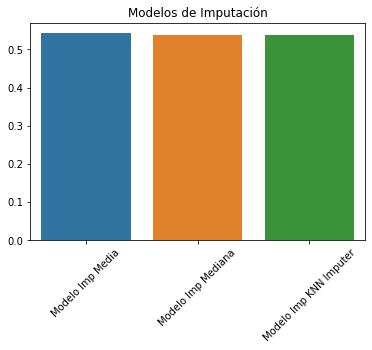

In [600]:
sns.barplot(data=Datos,x=Tipos, y=Rcuadrado_train)
plt.xticks(rotation = 45)
plt.title('Modelos de Imputación')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Si bien hay una leve diferencia en los modelos de Bench, proseguiré a evaluar la distribución y elegiré aquel modelo en los cuales no haya habido varios cambios en la distribución.

Grafico las variables con el data set original para comparar las distribuciones de los data sets imputados con la de los **datos originales**.

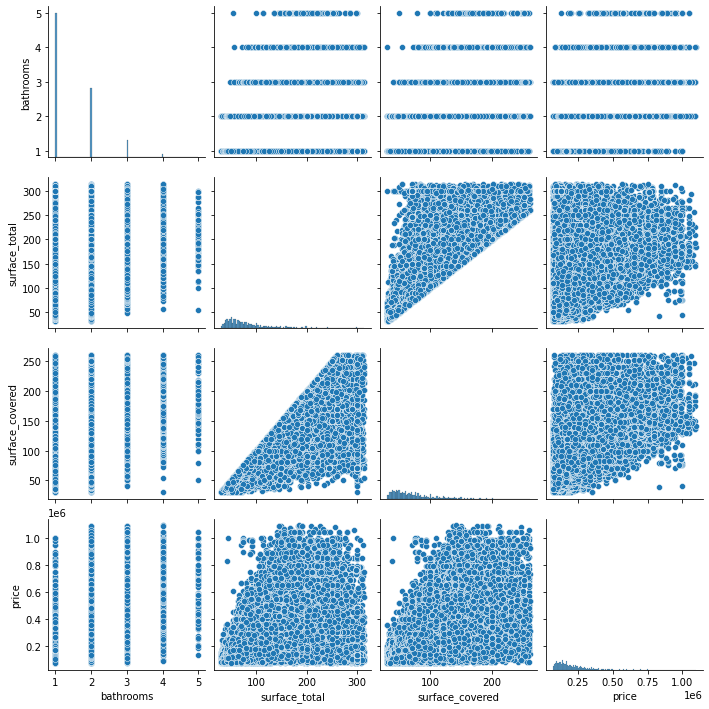

In [601]:
mascara0=(data_ml1.price<1099000)&(data_ml1.price>70000)&(data_ml1.bathrooms<6)&(data_ml1.surface_covered>29)&(data_ml1.surface_covered<262)&(data_ml1.surface_total>30)&(data_ml1.surface_total<315)
sns.pairplot(data=data_ml1[mascara0])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Grafico las variables con el data set imputado con la **media**.

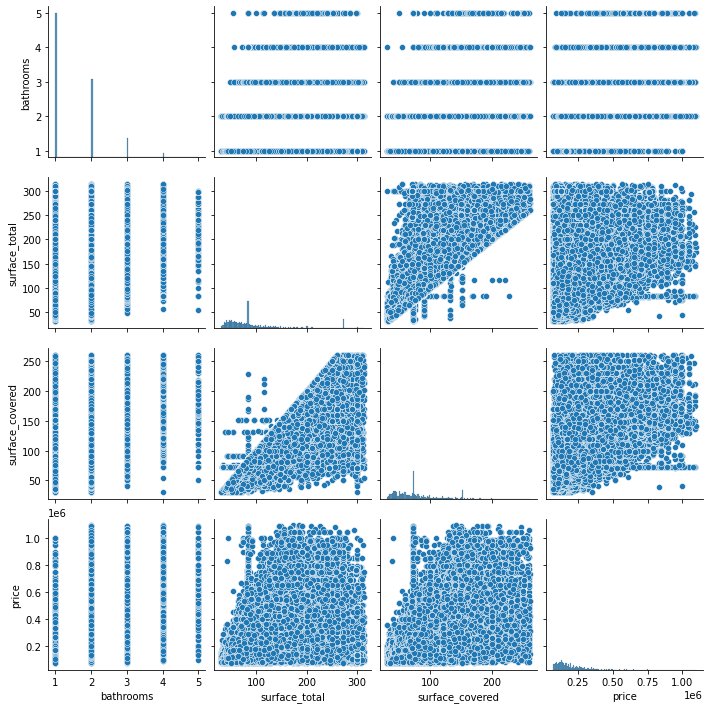

In [602]:
mascara1=(data_media_ml.price<1099000)&(data_media_ml.bathrooms<6)&(data_media_ml.price>70000)&(data_media_ml.surface_covered>29)&(data_media_ml.surface_covered<262)&(data_media_ml.surface_total>30)&(data_media_ml.surface_total<315)
sns.pairplot(data=data_media_ml[mascara1])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Grafico las variables con el data set imputado con la **mediana**.

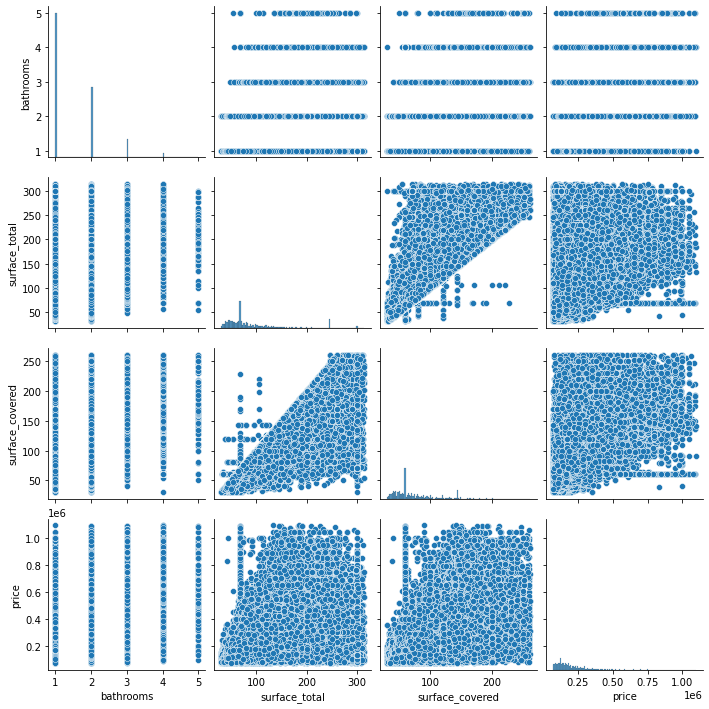

In [603]:
mascara2=(data_mediana_ml.price<1099000)&(data_mediana_ml.bathrooms<6)&(data_mediana_ml.price>70000)&(data_mediana_ml.surface_covered>29)&(data_mediana_ml.surface_covered<262)&(data_mediana_ml.surface_total>30)&(data_mediana_ml.surface_total<315)
sns.pairplot(data=data_mediana_ml[mascara2])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Grafico las variables con el data set imputado con **KNN Imputer**.

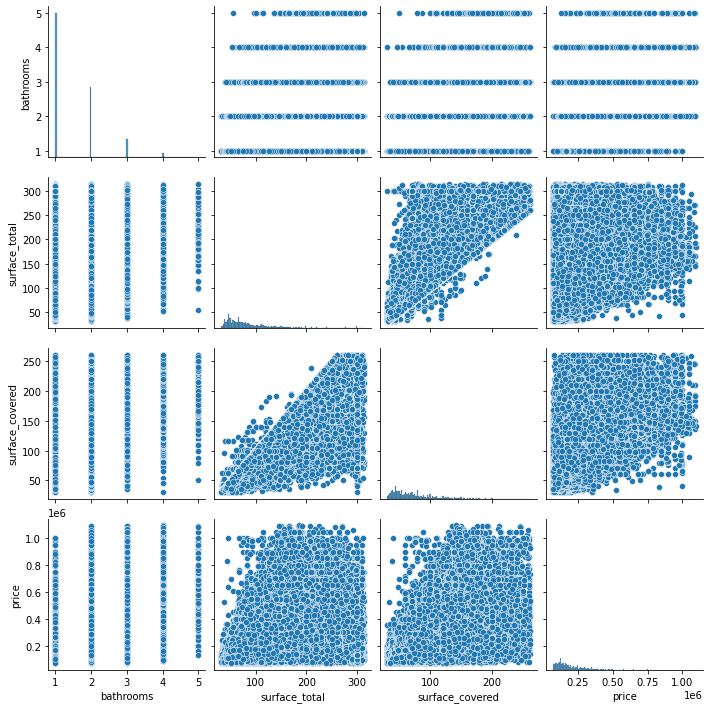

In [604]:
mascara3=(data_KNN_ml.price<1099000)&(data_KNN_ml.bathrooms<6)&(data_KNN_ml.price>70000)&(data_KNN_ml.surface_covered>29)&(data_KNN_ml.surface_covered<262)&(data_KNN_ml.surface_total>30)&(data_KNN_ml.surface_total<315)
sns.pairplot(data=data_KNN_ml[mascara3])
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como podemos visualizar el data set con imputación KNN podemos notar que no hay una distribución en las variables **Superficie Total y Superficie Cubierta**. Por otro lado en las otras dos imputaciones (media y mediana) podemos notar que cambia dicha distribución.

También podemos ver como la imputación ha impactado en propiedades donde la superficie cubierta es mayor a la total y viceversa.
Podría realizar un código para que iguale ambas superficies, pero proseguiré a realizarle una imputación mediante el método de regresión lineal para ver si me corrige dicha error.

Por lo que optare por la imputación por **KNN Imputer** dado que no varía la distribución de la superficie cubierta ni de la superfice total.

In [605]:
data_ml12=data_ml.copy()

In [606]:
d1=data_ml12['property_type']=='Cochera' #Tal como dije anteriormente elimino los datos de "Cochera" dado que tiene nulos ambos atributos y son insignificantes
data_ml12[d1].count()
data_ml12.drop(data_ml12[data_ml12['property_type']=='Cochera'].index,inplace=True)
data_ml12.shape

(132392, 17)

In [607]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
data_KNN_reg=data_KNN.copy()

In [608]:
model=linear_model.LinearRegression()

In [609]:
model.fit(X=data_KNN_reg[['surface_covered']],y=data_KNN_reg[['surface_total']])

LinearRegression()

In [610]:
data_KNN_reg.loc[data_ml12['surface_total'].isnull(),'Surface_total_impu']=model.predict(data_KNN_reg[['surface_covered']])[data_ml12[['surface_total']].isnull()]

In [611]:
data_KNN_reg[['surface_total','Surface_total_impu']]

,surface_total,Surface_total_impu
0,140.00000,NaN
1,70.00000,NaN
2,45.00000,NaN
3,85.00000,NaN
5,56.00000,NaN
...,...,...
146655,54.00000,NaN
146656,164.00000,NaN
146657,50.00000,NaN
146658,38.00000,NaN


In [612]:
data_KNN_reg.loc[data_ml12['surface_total'].isnull(),'surface_total']=model.predict(data_KNN_reg[['surface_covered']])[data_ml12[['surface_total']].isnull()]
data_KNN_reg.drop('Surface_total_impu',axis=1,inplace=True)

In [613]:
model.fit(X=data_KNN_reg[['surface_total']],y=data_KNN_reg[['surface_covered']])

LinearRegression()

In [614]:
data_KNN_reg.loc[data_ml12['surface_covered'].isnull(),'Surface_covered_impu']=model.predict(data_KNN_reg[['surface_total']])[data_ml12[['surface_covered']].isnull()]

In [615]:
data_KNN_reg[['surface_covered','Surface_covered_impu']]

,surface_covered,Surface_covered_impu
0,140.00000,NaN
1,58.00000,NaN
2,45.00000,NaN
3,50.00000,NaN
5,56.00000,NaN
...,...,...
146655,48.00000,NaN
146656,90.00000,NaN
146657,35.00000,NaN
146658,38.00000,NaN


In [616]:
data_KNN_reg.loc[data_ml12['surface_covered'].isnull(),'surface_covered']=model.predict(data_KNN_reg[['surface_total']])[data_ml12[['surface_covered']].isnull()]
data_KNN_reg.drop('Surface_covered_impu',axis=1,inplace=True)

In [617]:
model.fit(X=data_KNN_reg[['bedrooms']],y=data_KNN_reg[['bathrooms']])

LinearRegression()

In [618]:
data_KNN_reg.loc[data_ml12['bathrooms'].isnull(),'bathrooms_impu']=model.predict(data_KNN_reg[['bedrooms']])[data_ml12[['bathrooms']].isnull()]

In [619]:
data_KNN_reg[['bathrooms','bathrooms_impu']]

,bathrooms,bathrooms_impu
0,2.00000,NaN
1,2.00000,NaN
2,1.00000,NaN
3,1.00000,NaN
5,1.00000,NaN
...,...,...
146655,1.00000,NaN
146656,2.00000,NaN
146657,1.00000,NaN
146658,1.00000,NaN


In [620]:
data_KNN_reg.loc[data_ml12['bathrooms'].isnull(),'bathrooms']=model.predict(data_KNN_reg[['bedrooms']])[data_ml12[['bathrooms']].isnull()]
data_KNN_reg.drop('bathrooms_impu',axis=1,inplace=True)
data_KNN_reg['bathrooms']=round(data_KNN_reg['bathrooms'])

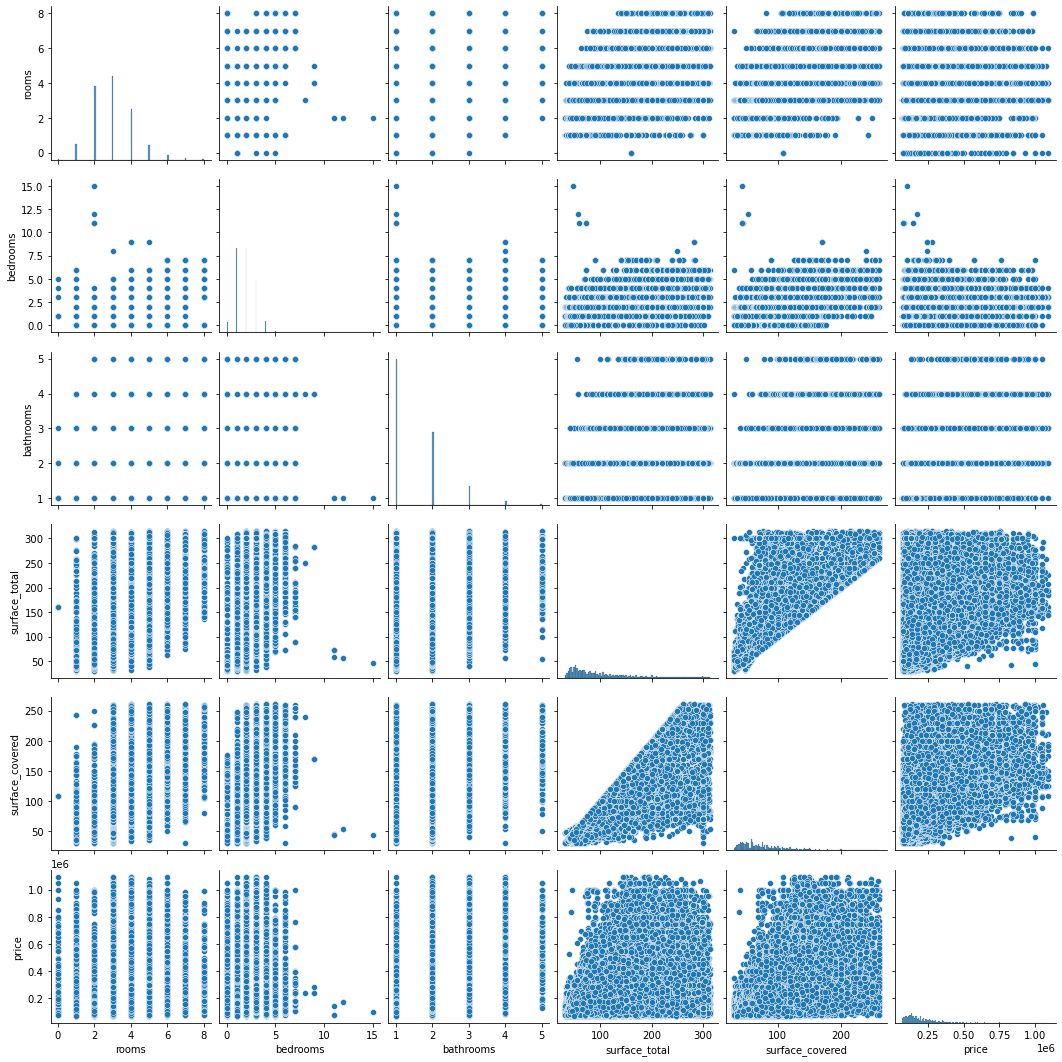

In [621]:
mascara4=(data_KNN_reg.price<1099000)&(data_KNN_reg.bathrooms<6)&(data_KNN_reg.price>70000)&(data_KNN_reg.surface_covered>29)&(data_KNN_reg.surface_covered<262)&(data_KNN_reg.surface_total>30)&(data_KNN_reg.surface_total<315)
sns.pairplot(data=data_KNN_reg[mascara4])

Podemos visualizar como los datos inconsistentes en la superficie cubierta y superficie total fueron imputados nuevamente por datos consistentes. **Por lo que sirvió hacer la doble imputación.**

Realizaré los mismos filtros que en el Proyecto 1 para poder comparar mis modelos y poder ir mejorandolo.

In [622]:
mascaraml=(data_KNN_reg.Zona=='Capital Federal')&((data_KNN_reg.property_type=='Departamento')|(data_KNN_reg.property_type=='Casa')|(data_KNN_reg.property_type=='PH'))&(data_KNN_reg.surface_total>=15)&(data_KNN_reg.surface_total<=1000)&(data_KNN_reg.price<=4000000)
data_KNN_reg[mascaraml].count()
data_ml1=data_KNN_reg[mascaraml][['rooms','bedrooms','bathrooms','surface_total','surface_covered','Distrito','price']]
data_ml_zona=data_KNN_reg[['rooms','bedrooms','bathrooms','surface_total','surface_covered','Distrito','Zona','price']]

In [623]:
data_ml1.shape

(86349, 7)

In [624]:
data_KNN_reg.shape
##Dataset con todos los datos imputados bajo el método de KNN en una primera instancia y luego realizado una regresión lineal.

(132392, 17)

Podemos notar como se fue reduciendo el data set a medida que le fui aplicando los filtros. Quedando un dataset con 84.179 de instancias y 7 Atributos.

Visualizaré la matriz de correlación para identificar cuales son las variables que mas se correlacionan a la variable y del proyecto **Precio**

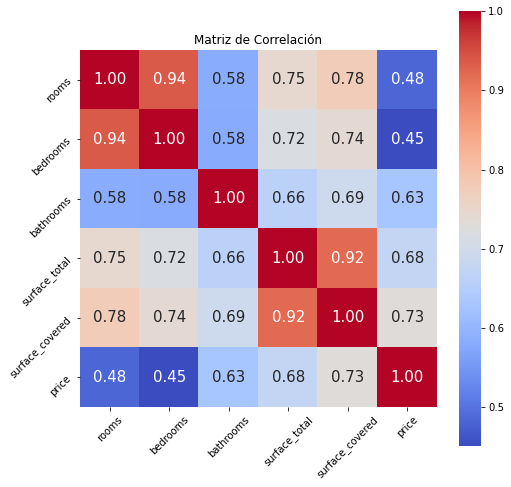

In [625]:
corr = data_ml1.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title("Matriz de Correlación")
plt.show()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Visualizando la matriz de Correlación podemos notar en una primer instancia una gran correlación entre la variable rooms y bedrooms. Luego también notamos una fuerte correlación entre las variables Superficie Total y Superficie Cubierta. Podemos concluir que dichas variables se explican entre sí por lo que en el modelo utilizaremos una variable de ambos pares, para no penalizar el modelo.

En este Proyecto, la variable que nos interesariía analizar es la variable "Precio", por lo que sería ocurrente analizar la última fila, y los datos que tenga un valor cercano a 1, querrá decir que tienen una correlación con dicha variable,

Voy a realizar mi primer modelo que será el Modelo del Proyecto 1, donde será un árbol de decisión con los datos simples, si bien la diferencia que podremos notar es que dichos datos van a estar imputados y sin outliers. Pero va a ser nuestro modelo base a ir mejorando a lo largo del Proyecto 2.

In [626]:
X=data_ml1.drop(columns=['price','Distrito','bedrooms','surface_total'])
y=data_ml1['price']

In [627]:
X.head() #En principio empezaré con estas 3 variables tal como en el proyecto anterior.

,rooms,bathrooms,surface_covered
0,7.00000,2.00000,140.00000
1,2.00000,2.00000,58.00000
2,2.00000,1.00000,45.00000
3,2.00000,1.00000,50.00000
5,2.00000,1.00000,56.00000


In [628]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [629]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
z1=[]
z2=[]
for i in range(1,20):
    tree_regressor = DecisionTreeRegressor(max_depth=i)
    tree_regressor.fit(X_train, y_train)
    y_pred_train=tree_regressor.predict(X_train)
    y_pred_test=tree_regressor.predict(X_test)
    z1.append(r2_score(y_train,y_pred_train))
    z2.append(r2_score(y_test,y_pred_test))

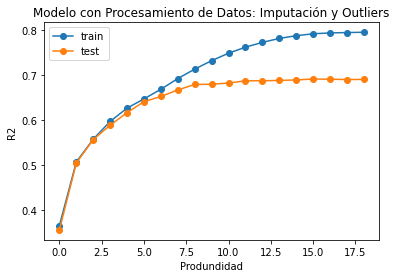

In [630]:
plt.title('Modelo con Procesamiento de Datos: Imputación y Outliers')
plt.plot(z1,'o-',label='train' )
plt.plot(z2,'o-',label='test')
plt.legend()
plt.xlabel('Produndidad')
plt.ylabel('R2')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [631]:
R2_test=max(z2)
R2_train=max(z1)

In [632]:
from sklearn.metrics import mean_squared_error
tree_regressor = DecisionTreeRegressor(max_depth=15)
tree_regressor.fit(X_train, y_train)
y_pred_train=tree_regressor.predict(X_train)
y_pred_test=tree_regressor.predict(X_test)
R2_train0=r2_score(y_train,y_pred_train)
R2_test0=r2_score(y_test,y_pred_test)
test0_r2_ajust = 1-(1-R2_test0)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
train0_r2_ajust = 1-(1-R2_train0)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
rmse_train0 = np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_test0 = np.sqrt(mean_squared_error(y_test,y_pred_test))

print("R2:",R2_train0,R2_test0,"R2 Ajustado:",train0_r2_ajust,test0_r2_ajust)

R2: 0.7868185881358802 0.6886880966690345 R2 Ajustado: 0.7868087120725111 0.6886448268529675


Podemos visualizar una alta varianza dado la gran diferencia entre el modelo de entrenamiento y el de testeo. Tambíen podemos notar un alto sesgo. A lo largo de este proyecto iremos disminuyendo dichos errores.

**Modelo del primer proyecto**

In [633]:
data_ml_original= data.copy()

In [634]:
mascaraml=(data_ml_original.Zona=='Capital Federal')&((data_ml_original.property_type=='Departamento')|(data_ml_original.property_type=='Casa')|(data_ml_original.property_type=='PH'))&(data_ml_original.surface_total>=15)&(data_ml_original.surface_total<=1000)&(data_ml_original.price<=4000000)
data_ml_original[mascaraml].count()
data_ml_original1=data_ml_original[mascaraml][['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']]
data_ml_original1.isnull().sum()

rooms                0
bedrooms             0
bathrooms          880
surface_total        0
surface_covered    517
price                0
dtype: int64

En el primer proyecto eliminamos los datos faltantes, por lo que haré la elimincación

In [635]:
data_ml2_original=data_ml_original1.dropna()
data_ml2_original.isnull().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
dtype: int64

In [636]:
X1_or=data_ml2_original[['rooms','bathrooms','surface_covered']]
y1_or=data_ml2_original['price']

In [637]:
train,test=train_test_split(data_ml2_original,random_state=0,train_size=0.7,test_size=0.3)

In [638]:
X1_train_or,X1_test_or,y1_train_or,y1_test_or=train_test_split(X1_or,y1_or)

In [639]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
tree_regressor_or = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_regressor_or.fit(X1_train_or, y1_train_or)
y1_pred_train_or=tree_regressor_or.predict(X1_train_or)
y1_pred_test_or=tree_regressor_or.predict(X1_test_or)
train1_or=r2_score(y1_train_or,y1_pred_train_or)
test1_or=r2_score(y1_test_or,y1_pred_test_or)
rmse_train1_or = np.sqrt(mean_squared_error(y1_train_or,y1_pred_train_or))
rmse_test1_or = np.sqrt(mean_squared_error(y1_test_or,y1_pred_test_or))

print(train1_or,test1_or)

0.8712831209504416 0.7659385462321233


In [640]:
dicc={"R2":[train1_or,R2_train0,test1_or,R2_test0],"Split":["Train","Train","Test","Test"],"Modelo":["Original Proyecto I","Con Outliers e Imputación","Original Proyecto I","Con Outliers e Imputación"]}

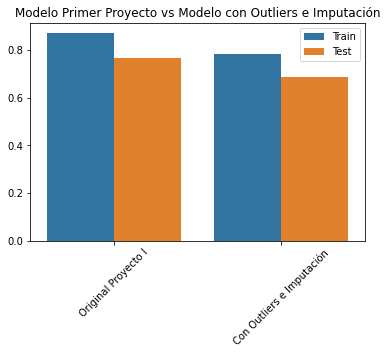

In [641]:
sns.barplot(data=dicc,x="Modelo", y="R2",hue="Split")
plt.xticks(rotation = 45)
plt.title("Modelo Primer Proyecto vs Modelo con Outliers e Imputación")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Si bien pensamos que el Preprocesamiento iba a aumentar el R2, puede que la imputación haya sido efectiva pero al eliminar dichos datos el modelos se adapta mejor. Lo que se puede notar es una menor varianza entre el modelo de entrenamiento y de testeo, comparado con el Original del Primer Proyecto pero podemos notar un sesgo mas grande que el modelo Original del Primer Proyecto.

In [642]:
dicc_rmse={"RMSE":[rmse_train1_or,rmse_train0,rmse_test1_or,rmse_test0],"Split":["Train","Train","Test","Test"],"Modelo":["Original Proyecto I","Con Outliers e Imputación","Original Proyecto I","Con Outliers e Imputación"]}

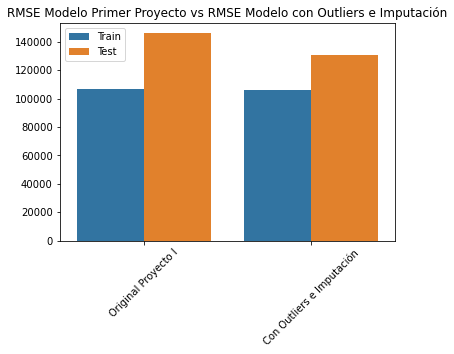

In [643]:
sns.barplot(data=dicc_rmse,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("RMSE Modelo Primer Proyecto vs RMSE Modelo con Outliers e Imputación")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Si bien con el R2 de testeo no notamos un resultado mejor, podemos notar como disminuye el error cuadrático medio. Al tener los datos sin estandarizar el error es representativo con respecto a la variable precio.

In [644]:
data_ml2=data_ml1.copy()

**Escalado de datos**

Antes de realizar el encoding, voy a realizar el escalado de datos.

In [645]:
from sklearn.preprocessing import StandardScaler
#Voy a utilizar el método de StandardScaler donde las variables numéricas se veran estandarizadas para mejorar las métricas del modelo.

In [646]:
X=data_ml2.drop(columns='Distrito')
Scaler=StandardScaler()
Scaler.fit(X)
X_scaled=Scaler.transform(X)

In [647]:
##data_l2_scaled contiene los datos estandarizados y data_ml2 contiene los datos reales, para luego comparar el modelo del primer proyecto con los modelos mejorados en este segundo proyecto.

In [648]:
X1=pd.DataFrame(X_scaled)
X1.head()

,0,1,2,3,4,5
0,3.46693,5.07560,0.58927,0.82962,1.33806,-0.40223
1,-0.81450,-0.95113,0.58927,-0.35421,-0.44455,-0.37624
2,-0.81450,-0.95113,-0.68048,-0.77700,-0.72716,-0.52351
3,-0.81450,-0.95113,-0.68048,-0.10053,-0.61846,0.21283
4,-0.81450,-0.95113,-0.68048,-0.59097,-0.48803,-0.41523


In [649]:
X.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000
1,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000
2,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000
3,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000
5,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000


In [650]:
data_ml2.rooms=X1[[0]].values
data_ml2.bedrooms=X1[[1]].values
data_ml2.bathrooms=X1[[2]].values
data_ml2.surface_total=X1[[3]].values
data_ml2.surface_covered=X1[[4]].values
data_ml2.price=X1[[5]].values

In [651]:
data_ml2.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,Distrito,price
0,3.46693,5.07560,0.58927,0.82962,1.33806,San Cristobal,-0.40223
1,-0.81450,-0.95113,0.58927,-0.35421,-0.44455,Boedo,-0.37624
2,-0.81450,-0.95113,-0.68048,-0.77700,-0.72716,Palermo,-0.52351
3,-0.81450,-0.95113,-0.68048,-0.10053,-0.61846,Palermo,0.21283
5,-0.81450,-0.95113,-0.68048,-0.59097,-0.48803,Villa Crespo,-0.41523


In [652]:
data_ml2.shape

(86349, 7)

Previo a realizar el encoding vamos a ver cuanto nos da el Modelo con el procesamiento de datos con Imputación, Outliers y Escalado. Voy a realizar un Modelo de Árbol de Decisión.

In [653]:
X_original=data_ml2.drop(columns=['price','Distrito','bedrooms','surface_total'])
y_original=data_ml2['price']

In [654]:
X_original.head() #Mismas variables con los datos normalizados.

,rooms,bathrooms,surface_covered
0,3.46693,0.58927,1.33806
1,-0.81450,0.58927,-0.44455
2,-0.81450,-0.68048,-0.72716
3,-0.81450,-0.68048,-0.61846
5,-0.81450,-0.68048,-0.48803


In [655]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(data_ml2,random_state=0,train_size=0.7,test_size=0.3)

In [656]:
X_or_train,X_or_test,y_or_train,y_or_test=train_test_split(X_original,y_original)

In [657]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
z4=[]
z5=[]
for i in range(1,20):
    tree_regressor = DecisionTreeRegressor(max_depth=i)
    tree_regressor.fit(X_or_train, y_or_train)
    y_or_pred_train=tree_regressor.predict(X_or_train)
    y_or_pred_test=tree_regressor.predict(X_or_test)
    z4.append(r2_score(y_or_train,y_or_pred_train))
    z5.append(r2_score(y_or_test,y_or_pred_test))

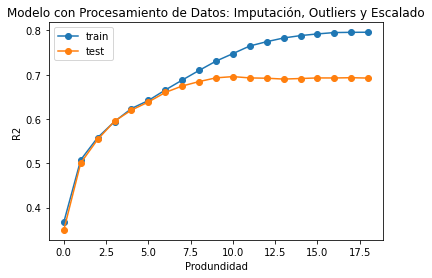

In [658]:
plt.title('Modelo con Procesamiento de Datos: Imputación, Outliers y Escalado')
plt.plot(z4,'o-',label='train' )
plt.plot(z5,'o-',label='test')
plt.legend()
plt.xlabel('Produndidad')
plt.ylabel('R2')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [659]:
R2_test_or=max(z5)
R2_train_or=max(z4)

In [660]:
from sklearn.metrics import mean_squared_error
tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_regressor.fit(X_or_train, y_or_train)
y_or_pred_train=tree_regressor.predict(X_or_train)
y_or_pred_test=tree_regressor.predict(X_or_test)
R2_train1=r2_score(y_or_train,y_or_pred_train)
R2_test1=r2_score(y_or_test,y_or_pred_test)
test1_r2_ajust = 1-(1-R2_test1)*(len(y_or_test)-1)/(len(y_or_test)-X_or_test.shape[1]-1)
train1_r2_ajust = 1-(1-R2_train1)*(len(y_or_train)-1)/(len(y_or_train)-X_or_train.shape[1]-1)
rmse_train1 = np.sqrt(mean_squared_error(y_or_train,y_or_pred_train))
rmse_test1 = np.sqrt(mean_squared_error(y_or_test,y_or_pred_test))
print("R2:",R2_train1,R2_test1,"R2 Ajustado:",train1_r2_ajust,test1_r2_ajust)

R2: 0.7882337256853785 0.6914556344590816 R2 Ajustado: 0.7882239151811405 0.6914127493082003


In [661]:
dicc={"R2":[R2_train,R2_train_or,R2_test,R2_test_or],"Split":["Train","Train","Test","Test"],"Modelo":["Sin Escalado","Con Escalado","Sin Escalado","Con Escalado"]}

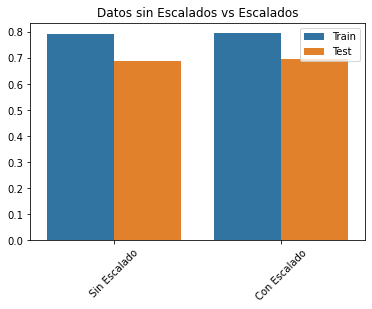

In [662]:
sns.barplot(data=dicc,x="Modelo", y="R2",hue="Split")
plt.xticks(rotation = 45)
plt.title("Datos sin Escalados vs Escalados")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Se puede notar una breve diferencia entre el data set con imputación y outliers, y aquel que además fue escalado. Por lo que proseguiré a realizar el encoding para ver si mejora.

Lo que podemos notar es una gran varianza en nuestros modelos y tambíen un alto sesgo por lo que a lo largo del Proyecto, iremos buscando un equilibrio entre Sesgo y Varianza.

Una vez realizado el escalado de los datos voy a pasar a realizar el encoding agregando al modelo una variable categórica pero muy importante dado que es el **Distrito**, que creo que es muy significante a la hora de analizar el dataset.

In [663]:
data_con_dummies1 = pd.get_dummies(data_ml2, drop_first=True)
data_con_dummies1.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Distrito_Agronomía,Distrito_Almagro,Distrito_Balvanera,Distrito_Barracas,...,Distrito_Villa Lugano,Distrito_Villa Luro,Distrito_Villa Ortuzar,Distrito_Villa Pueyrredón,Distrito_Villa Real,Distrito_Villa Riachuelo,Distrito_Villa Santa Rita,Distrito_Villa Soldati,Distrito_Villa Urquiza,Distrito_Villa del Parque
0,3.46693,5.07560,0.58927,0.82962,1.33806,-0.40223,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.81450,-0.95113,0.58927,-0.35421,-0.44455,-0.37624,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.81450,-0.95113,-0.68048,-0.77700,-0.72716,-0.52351,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.81450,-0.95113,-0.68048,-0.10053,-0.61846,0.21283,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.81450,-0.95113,-0.68048,-0.59097,-0.48803,-0.41523,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [664]:
X_dummies=data_con_dummies1.drop(columns=['price','bedrooms','surface_total'])
y_dummies=data_con_dummies1['price']

In [665]:
X_dummies.head() #Agregamos los atributos del encoding

,rooms,bathrooms,surface_covered,Distrito_Agronomía,Distrito_Almagro,Distrito_Balvanera,Distrito_Barracas,Distrito_Barrio Norte,Distrito_Belgrano,Distrito_Boca,...,Distrito_Villa Lugano,Distrito_Villa Luro,Distrito_Villa Ortuzar,Distrito_Villa Pueyrredón,Distrito_Villa Real,Distrito_Villa Riachuelo,Distrito_Villa Santa Rita,Distrito_Villa Soldati,Distrito_Villa Urquiza,Distrito_Villa del Parque
0,3.46693,0.58927,1.33806,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.81450,0.58927,-0.44455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.81450,-0.68048,-0.72716,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.81450,-0.68048,-0.61846,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.81450,-0.68048,-0.48803,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [666]:
train,test=train_test_split(data_con_dummies1,random_state=0,train_size=0.7,test_size=0.3)

In [667]:
X_dum_train,X_dum_test,y_dum_train,y_dum_test=train_test_split(X_dummies,y_dummies)

In [668]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
z6=[]
z7=[]
for i in range(1,20):
    tree_regressor = DecisionTreeRegressor(max_depth=i)
    tree_regressor.fit(X_dum_train, y_dum_train)
    y_dum_pred_train=tree_regressor.predict(X_dum_train)
    y_dum_pred_test=tree_regressor.predict(X_dum_test)
    z6.append(r2_score(y_dum_train,y_dum_pred_train))
    z7.append(r2_score(y_dum_test,y_dum_pred_test))

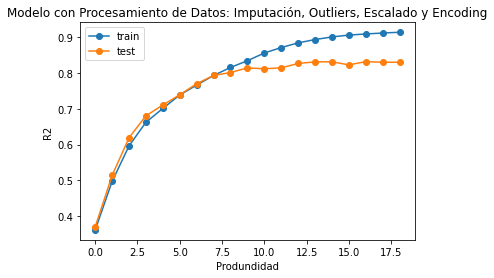

In [669]:
plt.title('Modelo con Procesamiento de Datos: Imputación, Outliers, Escalado y Encoding')
plt.plot(z6,'o-',label='train' )
plt.plot(z7,'o-',label='test')
plt.legend()
plt.xlabel('Produndidad')
plt.ylabel('R2')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [670]:
tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_regressor.fit(X_dum_train, y_dum_train)
y_dum_pred_train=tree_regressor.predict(X_dum_train)
y_dum_pred_test=tree_regressor.predict(X_dum_test)
R2_train2=r2_score(y_dum_train,y_dum_pred_train)
R2_test2=r2_score(y_dum_test,y_dum_pred_test)
test2_r2_ajust = 1-(1-R2_test2)*(len(y_dum_test)-1)/(len(y_dum_test)-X_dum_test.shape[1]-1)
train2_r2_ajust = 1-(1-R2_train2)*(len(y_dum_train)-1)/(len(y_dum_train)-X_dum_train.shape[1]-1)
rmse_train2 = np.sqrt(mean_squared_error(y_dum_train,y_dum_pred_train))
rmse_test2 = np.sqrt(mean_squared_error(y_dum_test,y_dum_pred_test))
print("R2:",R2_train2,R2_test2,"R2 Ajustado:",train2_r2_ajust,test2_r2_ajust)

R2: 0.9003344099167586 0.8225308580186659 R2 Ajustado: 0.9002435261620266 0.8220444830940608


Analzaré la posibilidad de agregar **la variable categórica de Zonas** para ver se le suma al modelo o no.

In [671]:
data_con_dummies23 = pd.get_dummies(data_ml_zona, drop_first=True)
data_con_dummies23.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Distrito_Agronomía,Distrito_Almagro,Distrito_Almirante Brown,Distrito_Avellaneda,...,Distrito_Villa Pueyrredón,Distrito_Villa Real,Distrito_Villa Riachuelo,Distrito_Villa Santa Rita,Distrito_Villa Soldati,Distrito_Villa Urquiza,Distrito_Villa del Parque,Zona_Bs.As. G.B.A. Zona Oeste,Zona_Bs.As. G.B.A. Zona Sur,Zona_Capital Federal
0,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2.00000,1.00000,1.00000,56.00000,56.00000,150000.00000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [672]:
X_dummies23=data_con_dummies23.drop(columns=['price','bedrooms','surface_total'])
y_dummies23=data_con_dummies23['price']

In [673]:
train,test=train_test_split(data_con_dummies23,random_state=0,train_size=0.7,test_size=0.3)

In [674]:
X_dum_train23,X_dum_test23,y_dum_train23,y_dum_test23=train_test_split(X_dummies23,y_dummies23)

In [675]:
tree_regressor23 = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_regressor23.fit(X_dum_train23, y_dum_train23)
y_dum_pred_train23=tree_regressor23.predict(X_dum_train23)
y_dum_pred_test23=tree_regressor23.predict(X_dum_test23)
R2_train23=r2_score(y_dum_train23,y_dum_pred_train23)
R2_test23=r2_score(y_dum_test23,y_dum_pred_test23)
test2_r2_ajust23 = 1-(1-R2_test23)*(len(y_dum_test23)-1)/(len(y_dum_test23)-X_dum_test23.shape[1]-1)
train2_r2_ajust23 = 1-(1-R2_train23)*(len(y_dum_train23)-1)/(len(y_dum_train23)-X_dum_train23.shape[1]-1)
print("R2:",R2_train23,R2_test23,"R2 Ajustado:",train2_r2_ajust23,test2_r2_ajust23)

R2: 0.7767447601356832 0.6744081691169026 R2 Ajustado: 0.7765332056588513 0.6734808100252136


Podemos notar que disminuyó ampliamente el R2. Por lo que **no fue una buena elección, seguiré con el modelo anterior**.

Visualizareos un gráfico donde podremos notar cuales de los atributos son mas relevantes dentro del modelo con la variable categórica **Distrito**.

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


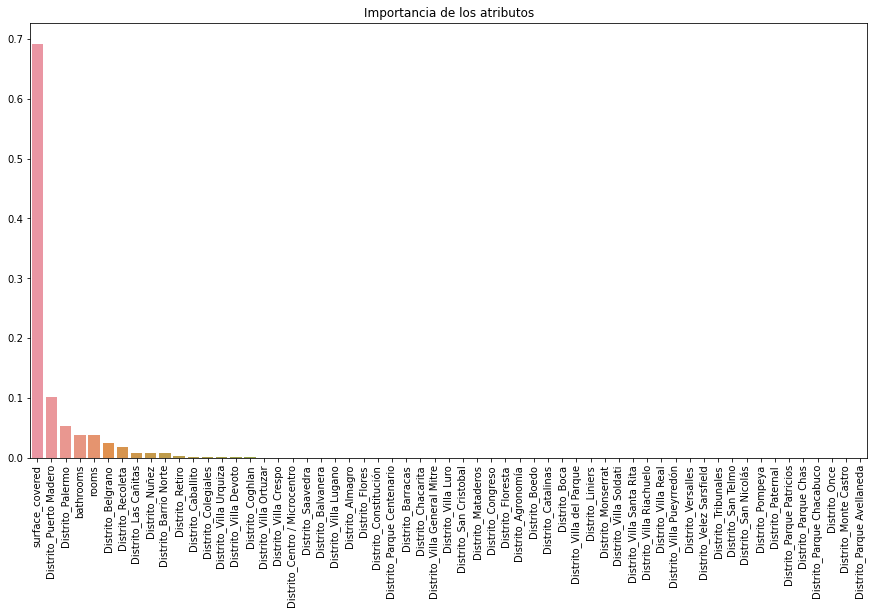

In [676]:
importances = tree_regressor.feature_importances_
columns = X_dum_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.xticks(rotation = 90)
plt.title("Importancia de los atributos")
plt.show()

Podemos notar como "Superficie Cubierta" y algunos distritos son los atributos mas significantes del modelo.

In [677]:
resultados={"R2":[R2_train0,R2_train1,R2_train2,R2_test0,R2_test1,R2_test2],"R2_Ajustado":[train0_r2_ajust,train1_r2_ajust,train2_r2_ajust,test0_r2_ajust,test1_r2_ajust,test2_r2_ajust],"Split":["Train","Train","Train","Test","Test","Test"],"Modelo":["Sin Escalado","Con Escalado","Con Escalado y Dummies","Sin Escalado","Con Escalado","Con Escalado y Dummies"]}

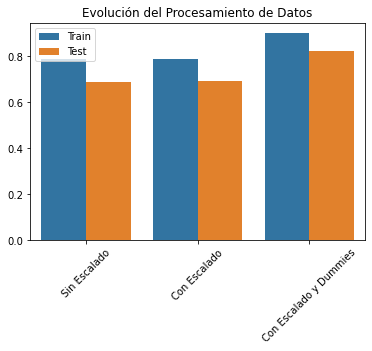

In [678]:
sns.barplot(data=resultados,x="Modelo", y="R2_Ajustado",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del Procesamiento de Datos")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar, como el modelo se vio mejorado con el Encoding. Comparamos los R2 Ajustados dado que queremos analizar si no me penaliza el modelo por haberle agregado 57 Variables por el Encoding. Podemos visualizar que el Modelo no penaliza por lo que es correcto realizarlo y el número de variables.

**Parte B y C, Modelos Avanzados e Interpretación de Modelos**

Dado que el modelo con Imputación de Datos, eliminación de outliers, escalado de datos y encoding es el mejor por ahora, proseguire con dicho data set.

Voy a realizar la validación cruzada para evitar la aleatoriedad del Modelo. La validación cruzada consiste en una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. La validación cruzada es una manera de predecir el ajuste de un modelo a un hipotético conjunto de datos de prueba cuando no disponemos del conjunto explícito de datos de prueba

In [679]:
from sklearn.model_selection import cross_val_score
scores=[]
for i in range(1,20):
    tree = DecisionTreeRegressor(max_depth=i)
    tree_scores = cross_val_score(tree, X_dummies, y_dummies, scoring='r2', cv=5)
    scores.append(tree_scores.mean())
    i+=1

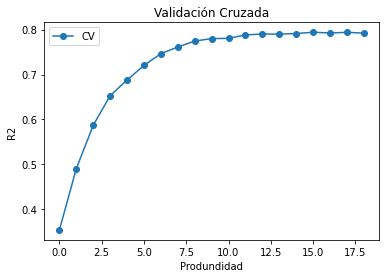

In [680]:
plt.title("Validación Cruzada")
plt.plot(scores,'o-',label='CV')
plt.legend()
plt.xlabel('Produndidad')
plt.ylabel('R2')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [681]:
tree_regressor_vc = DecisionTreeRegressor(max_depth=15,random_state=42)
tree_scores = cross_val_score(tree_regressor_vc, X_dummies, y_dummies, scoring='r2', cv=5)
tree_scores_rmse = cross_val_score(tree_regressor_vc, X_dummies, y_dummies, scoring='neg_mean_squared_error', cv=5)
R2_CV=tree_scores.mean()
RSME_CV=tree_scores_rmse.mean()
print(R2_CV)

0.7891878479566242


In [682]:
resultados1={"R2":[R2_train0,R2_train1,R2_train2,R2_test0,R2_test1,R2_test2,R2_CV],"Split":["Train","Train","Train","Test","Test","Test","CV"],"Modelo":["Sin Escalado","Con Escalado","Con Escalado y Dummies","Sin Escalado","Con Escalado","Con Escalado y Dummies","Validación Cruzada"]}

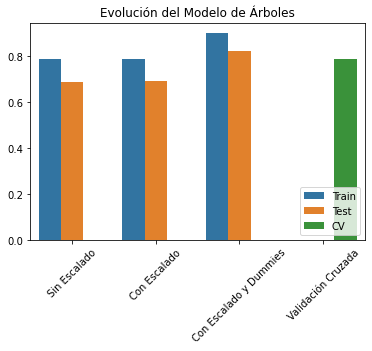

In [683]:
sns.barplot(data=resultados1,x="Modelo", y="R2",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del Modelo de Árboles")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar como el modelo con Validación Cruzada tiene un poco menor el R2 que el modelo previo sin validación, pero es necesario realizar una validación cruzada dado que se elimina el azar de la subdivisión de los datos seleccionados del entrenamiento y del testeo..

Vamos a realizar las Curvas de Validación teniendo en cuenta la validación cruzada. Donde podremos notar si hay una alta varianza y si existe algún tipo de sobre ajuste en el modelo.

In [684]:
from sklearn.model_selection import cross_validate
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    tree2 = DecisionTreeRegressor(max_depth=profundidad)
    tree_scores = cross_validate(tree2, X_dummies, y_dummies, cv=5,scoring='r2', return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

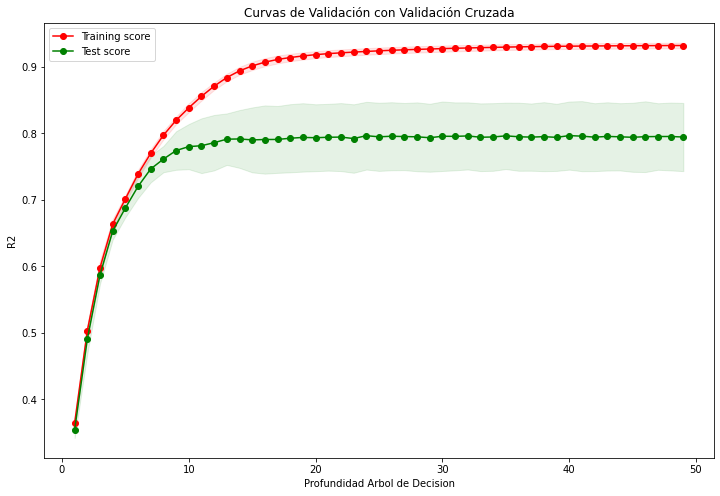

In [685]:
plt.figure(figsize=(12,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.title("Curvas de Validación con Validación Cruzada")
plt.legend()
plt.ylabel('R2')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

Podemos visualizar que existe una alta varianza, por lo que pareciera sobre ajustado el modelo. Dicho sobre ajuste lo optimizaremos mediante la Optimización de HiperParámetros.

**Optimización de HiperParámetros**

Los modelos de Machine Learning poseen algunos hiper parámetros que son variables en las que uno puede manejar y tomar decisiones sobre un determinado valor dependiendo el resultado del modelo.

Por lo que empezaré por optar poe el método de RandomSize Seearch para que vaya variando estos hiperparámetros entre rangos definidos y aleatoriamente vaya eligiendo distintas combinaciones para cada uno de ellos.

In [686]:
import scipy as sp #Libreria que me permite generar aleatoriedad de los rangos determinados
from sklearn.model_selection import RandomizedSearchCV

In [687]:
tree_regressor_2 = DecisionTreeRegressor()

In [688]:
param_grid_tree = {'criterion':['mse', 'mae'],
                   'max_depth' :sp.stats.randint(5, 19),
              'min_samples_split':sp.stats.randint(2, 5),
              'min_samples_leaf':sp.stats.randint(1,4)}

**Criterion**: La función para medir la calidad de una división. Los criterios admitidos son "mse" para el error cuadrático medio y "mae" para el error absoluto medio.

**Max depth**: profundidad máxima del árbol. Elijo valores de 5 a 19 dado que en el gráfico anterior podemos notar como se establizia en alrededor 20 de profundidad.

**Min_samples_split**:El número mínimo de muestras necesarias para dividir un nodo interno. Tienen que ser valores enteros y hasta 5 me parece un número lógico de subdivisión.

**Min_samples_leaf**:El número mínimo de muestras necesarias para estar en un nodo hoja

In [689]:
model = RandomizedSearchCV(tree_regressor_2, param_grid_tree,n_iter=10, random_state=42, scoring='r2',cv=5)
#Voy a evaluar la métrica r2 para que sea comparable con los anteriores modelos

El parámetro n_iter lo pongo en 10 debido a que me tarda mucho en procesar la computadora, entiendo igual que mientras mas iteraciones más posibilidaddes de encontrar los mejores hiperparámetros. Proseguiré con realizar un Grid Search sobre los mejores hiperparámetros para encontrar los mejores hiperparámetros.

In [239]:
#model.fit(X_dummies, y_dummies)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002055D1521C0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002055E2B83A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002055E2C7F10>},
                   random_state=42, scoring='r2')

In [240]:
#print("Mejores parametros: "+str(model.best_params_))
#print("Mejor Score: "+str(model.best_score_)+'\n')

#scores = pd.DataFrame(model.cv_results_)
#scores

Mejores parametros: {'criterion': 'mse', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 4}
Mejor Score: 0.7940972538833901



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.36123,0.00747,0.01416,0.00040,mse,8,1,4,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.73446,0.77691,0.76455,0.72448,0.79122,0.75832,0.02522,8
1,0.49388,0.01245,0.01476,0.00040,mse,12,1,2,"{'criterion': 'mse', 'max_depth': 12, 'min_sam...",0.75290,0.82678,0.79583,0.71485,0.82755,0.78358,0.04385,4
2,0.58763,0.05845,0.01696,0.00209,mse,14,3,4,"{'criterion': 'mse', 'max_depth': 14, 'min_sam...",0.78138,0.82043,0.79439,0.74701,0.82729,0.79410,0.02889,1
3,0.63131,0.07481,0.01755,0.00233,mse,15,1,4,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.74945,0.83297,0.79763,0.72343,0.84171,0.78904,0.04615,3
4,384.99114,5.62200,0.01576,0.00172,mae,9,2,3,"{'criterion': 'mae', 'max_depth': 9, 'min_samp...",0.72524,0.76546,0.74772,0.73047,0.77400,0.74858,0.01900,9
5,373.63786,21.24144,0.01536,0.00102,mae,6,1,2,"{'criterion': 'mae', 'max_depth': 6, 'min_samp...",0.67703,0.67394,0.67467,0.68515,0.68762,0.67968,0.00562,10
6,395.59596,3.97182,0.01696,0.00167,mae,14,2,2,"{'criterion': 'mae', 'max_depth': 14, 'min_sam...",0.73769,0.81671,0.78509,0.71382,0.81731,0.77413,0.04186,6
7,371.65081,4.95489,0.01576,0.00040,mae,13,1,4,"{'criterion': 'mae', 'max_depth': 13, 'min_sam...",0.74963,0.81325,0.77331,0.67705,0.81408,0.76546,0.05055,7
8,0.51781,0.00305,0.01516,0.00116,mse,14,3,3,"{'criterion': 'mse', 'max_depth': 14, 'min_sam...",0.78137,0.82045,0.79345,0.74697,0.82711,0.79387,0.02887,2
9,374.66565,3.27704,0.01636,0.00049,mae,18,3,4,"{'criterion': 'mae', 'max_depth': 18, 'min_sam...",0.74279,0.80732,0.78385,0.71876,0.82509,0.77556,0.03957,5


Una vez analizado la selección de la mejor combinación de Hiperparámetros mediante el método de RandomSize Search, porseguiré a realizar un Grid Search eligiendo rangos que se encuentren cercanos a la mejor combinación para lograr un resultado aún mejor.

Analizar un **Grid Search** para los casos cerca de los mejores parámetros seleccionados por el RandomsSize Search.

In [690]:
from sklearn.model_selection import GridSearchCV

In [691]:
param_grid = {'criterion':['mse'],
                   'max_depth' :np.arange(15, 20),
              'min_samples_split':np.arange(4, 6),
              'min_samples_leaf':np.arange(2,5)}

In [216]:
tree_regressor_3 = DecisionTreeRegressor()

In [217]:
#model2 = GridSearchCV(tree_regressor_3, param_grid=param_grid,scoring='r2', cv=5)

In [218]:
#model2.fit(X_dummies, y_dummies)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse'],
                         'max_depth': array([15, 16, 17, 18, 19]),
                         'min_samples_leaf': array([2, 3, 4]),
                         'min_samples_split': array([4, 5])},
             scoring='r2')

In [219]:
#print("Mejores parametros: "+str(model2.best_params_))
#print("Mejor Score: "+str(model2.best_score_)+'\n')
#Score_hiper=model2.best_score_
#scores2 = pd.DataFrame(model2.cv_results_)
#scores2

Mejores parametros: {'criterion': 'mse', 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 4}
Mejor Score: 0.8065358414066051



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.63929,0.10238,0.01676,0.00263,mse,15,2,4,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78360,0.83141,0.80701,0.75383,0.83380,0.80193,0.03020,25
1,0.57287,0.02262,0.01575,0.00116,mse,15,2,5,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78431,0.83099,0.80813,0.75233,0.83149,0.80145,0.03009,28
2,0.56569,0.02187,0.01596,0.00154,mse,15,3,4,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78527,0.82868,0.79834,0.76195,0.82842,0.80053,0.02568,30
3,0.55811,0.01342,0.01616,0.00193,mse,15,3,5,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78523,0.82868,0.79851,0.76179,0.82848,0.80054,0.02574,29
4,0.54993,0.00522,0.01516,0.00040,mse,15,4,4,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78599,0.82886,0.80433,0.76703,0.82522,0.80229,0.02343,24
5,0.55372,0.01219,0.01516,0.00040,mse,15,4,5,"{'criterion': 'mse', 'max_depth': 15, 'min_sam...",0.78595,0.82890,0.80433,0.76698,0.82528,0.80229,0.02347,23
6,0.57726,0.00686,0.01556,0.00080,mse,16,2,4,"{'criterion': 'mse', 'max_depth': 16, 'min_sam...",0.78640,0.83265,0.80808,0.75406,0.83480,0.80320,0.03028,18
7,0.57945,0.01916,0.01596,0.00109,mse,16,2,5,"{'criterion': 'mse', 'max_depth': 16, 'min_sam...",0.78501,0.83270,0.81006,0.75186,0.83238,0.80240,0.03076,21
8,0.57167,0.00569,0.01496,0.00063,mse,16,3,4,"{'criterion': 'mse', 'max_depth': 16, 'min_sam...",0.78655,0.82940,0.79957,0.76341,0.82903,0.80159,0.02535,27
9,0.57745,0.00830,0.01536,0.00049,mse,16,3,5,"{'criterion': 'mse', 'max_depth': 16, 'min_sam...",0.78655,0.82947,0.80014,0.76382,0.82905,0.80181,0.02524,26


Podemos notar que la mejor combinación dada por el método de Random Size Search dio un R2 de 80% y el método de Grid Search sobre rangos cercanos a esa combinación dio un R2 80,14%. Lo cual indica que he encontrado una combinación de hiper parámetros que mejora mi modelo.

In [695]:
tree_regressor_hiper = DecisionTreeRegressor(criterion='mse', max_depth=19, min_samples_leaf= 4, min_samples_split= 4)
tree_scores_hiper = cross_val_score(tree_regressor_hiper, X_dummies, y_dummies, scoring='r2', cv=5)
tree_scores_rmse_hiper = cross_val_score(tree_regressor_hiper, X_dummies, y_dummies, scoring='neg_mean_squared_error', cv=5)
R2_CV_hiper=tree_scores_hiper.mean()
RSME_CV_hiper=tree_scores_rmse_hiper.mean()
print(R2_CV)

0.7891878479566242


In [698]:
resultados12={"R2":[R2_train0,R2_train1,R2_train2,R2_test0,R2_test1,R2_test2,R2_CV,R2_CV_hiper],"Split":["Train","Train","Train","Test","Test","Test","CV","Hiperparámetros"],"Modelo":["Sin Escalado","Con Escalado","Con Escalado y Dummies","Sin Escalado","Con Escalado","Con Escalado y Dummies","Validación Cruzada","Con Hiperparámetros"]}

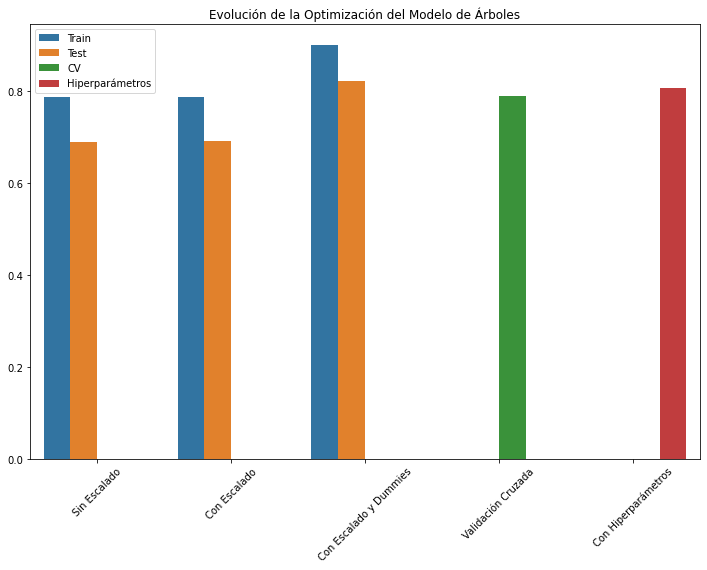

In [699]:
plt.figure(figsize=(12,8))
sns.barplot(data=resultados12,x="Modelo", y="R2",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución de la Optimización del Modelo de Árboles")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como bien podemos visualizar en el gráfico podemos notar como a medida que fui implementando distintos métodos tanto en el Preprocesamiento de Datos como luego en la optimización del Modelo, lo cual me fue dirigiendo a un modelo aún mejor, empezando con un modelo con un R2 del 68% y terminando con un R2 del 80,14%.

Para no quedarme con la utilización de un solo modelo, proseguiré a seleccionar un odelo de Regresión y lo iré mejorando mediante distintos métodos y luego lo compararé con mi modelo de árboles para elegir el mejor modelo.

In [700]:
resultados_RMSE={"RMSE":[rmse_train1,rmse_train2,rmse_test1,rmse_test2,RSME_CV,RSME_CV_hiper],"Split":["Train","Train","Test","Test","CV","Hiperparámetros"],"Modelo":["Con Escalado","Con Escalado y Dummies","Con Escalado","Con Escalado y Dummies","Validación Cruzada","Con Hiperparámetros"]}

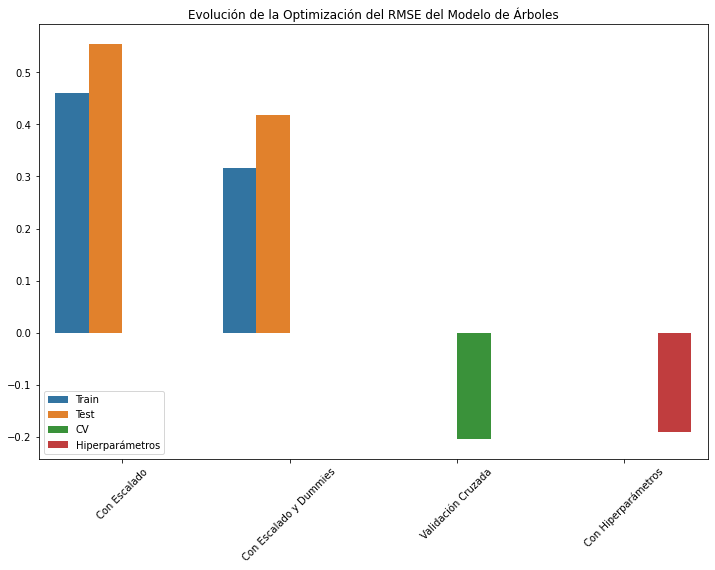

In [701]:
plt.figure(figsize=(12,8))
sns.barplot(data=resultados_RMSE,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución de la Optimización del RMSE del Modelo de Árboles")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Si bien pudimos notar como al aplicar la validación cruzada y con la optimización de Hiperparámetros no notamos una mejora notable en el R2, podemos notar como disminuyó el error cuadrático medio en la medida que optimizé el Modelo. A diferencia del análisis de la distribución de errores que hice anteriormente, podemos notar como se pierde cierta interpretación del error dado que los datos están estandarizados. Como dije anteriormente, buscaré reducir el error a la vez que voy optimizando el modelo.

**Regresión Lineal**

Si bien ya he realizado un modelo de árboles, me gustaría analizar si hay algún otro modelo que se adapte mejor al Data Set, es por eso que voy a analizar como se adaptan los datos a una Regresión Lineal e iré optimizando el modelo teniendo en cuenta algunos métodos.

In [702]:
X_dummies=data_con_dummies1.drop(columns=['price','bedrooms','surface_total'])
y_dummies=data_con_dummies1['price']

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

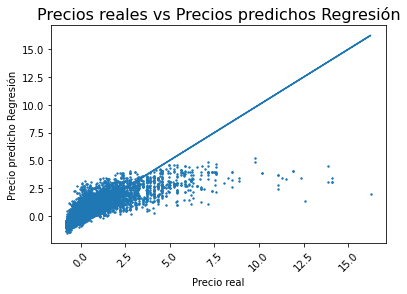

In [703]:
from sklearn.metrics import mean_squared_error
linear_model = LinearRegression()

X_dummies_train, X_dummies_test, y_dummies_train, y_dummies_test = train_test_split(X_dummies, y_dummies, test_size=0.30, random_state=42)

linear_model.fit(X_dummies_train, y_dummies_train)

y_train_pred_reg = linear_model.predict(X_dummies_train)
y_test_pred_reg = linear_model.predict(X_dummies_test)

train_r2_reg = r2_score(y_dummies_train,y_train_pred_reg)
train_r2_ajust_reg = 1-(1-train_r2_reg)*(len(y_dummies_train)-1)/(len(y_dummies_train)-X_dummies.shape[1]-1)
    
test_r2_reg = r2_score(y_dummies_test,y_test_pred_reg)
test_r2_ajust_reg = 1-(1-train_r2_reg)*(len(y_dummies_test)-1)/(len(y_dummies_test)-X_dummies.shape[1]-1)

rmse_train_reg = np.sqrt(mean_squared_error(y_dummies_train, y_train_pred_reg))
rmse_test_reg = np.sqrt(mean_squared_error(y_dummies_test, y_test_pred_reg))

#print(f'R2 ajustado en Train: {round(train_r2_ajust_bench,4)}')
#print(f'R2 ajustado en Test: {round(test_r2_ajust_bench,4)}')
#print(f'Raíz del error cuadrático medio en Train: {round(rmse_train_bench)}')
#print(f'Raíz del error cuadrático medio en Test: {round(rmse_test_bench)}')

plt.scatter(y_dummies_test,y_test_pred_reg, s =2)
plt.plot(y_dummies_test,y_dummies_test)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho Regresión")
plt.title("Precios reales vs Precios predichos Regresión",fontsize=16)
plt.xticks(rotation=45)

Podemos visualizar que para un cierto precio el modelo podría adaptarse a una linealidad, pero a medida que aumenta el Precio la linealidad, el modelo deja de explicar de una manera óptima a los datos.

In [704]:
print(test_r2_reg,test_r2_ajust_reg,rmse_test_reg)

0.6828643361786257 0.6766328246586472 0.552251628214522


Como podemos notar, el modelo no se ajusta bien a los datos, vamos a seguir mejorandolo, pero puede que una solución sea que no haya una linealidad, por lo que también intentaremos aplicar atributos polinómicos.

Voy a realizar en primer instancia la validación cruzada.

In [705]:
X_train_reg1, X_test_reg1, y_train_reg1, y_test_reg1 = train_test_split(X_dummies, y_dummies, test_size=0.30)
linear_modelo = LinearRegression()

tree_scores = cross_val_score(linear_modelo , X_dummies, y_dummies, scoring='r2', cv=5)
print("R2 para Regresión: %0.5f (+/- %0.5f)" % (tree_scores.mean(), tree_scores.std() ))

R2 para Regresión: 0.67358 (+/- 0.01978)


Vamos a realizar una polonimización de los atributos para el caso de que no exista una linealidad en los datos y si es así, podremos mejorar el modelo. Dado que como notamos en el gráfico anterior se podía visualizar que para un cierto precio determinado, existe una linealidad pero a medida que ese precio aumenta, la linealidad pareciera no ser el mejor modelo.

In [706]:
from sklearn.preprocessing import PolynomialFeatures

In [707]:
X_train_reg1, X_test_reg1, y_train_reg1, y_test_reg1 = train_test_split(X_dummies, y_dummies, test_size=0.30)

In [708]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree= 2, include_bias=False) 
X_train_new1 = poly.fit_transform(X_train_reg1)
X_test_new1 = poly.fit_transform(X_test_reg1)

reg_2 = LinearRegression()
reg_2.fit(X_train_new1, y_train_reg1)

y_train_pred_reg_2 = reg_2.predict(X_train_new1)
y_test_pred_reg_2 = reg_2.predict(X_test_new1)

Train_score1= r2_score(y_train_reg1,y_train_pred_reg_2)
Test_score1= r2_score(y_test_reg1,y_test_pred_reg_2)
rmse_train_reg_2 = np.sqrt(mean_squared_error(y_train_reg1, y_train_pred_reg_2))
rmse_test_reg_2 = np.sqrt(mean_squared_error(y_test_reg1, y_test_pred_reg_2))

test_score1_r2_ajust_reg = 1-(1-Test_score1)*(len(y_test_reg1)-1)/(len(y_test_reg1)-X_dummies.shape[1]-1)

print(Train_score1,Test_score1,test_score1_r2_ajust_reg,rmse_test_reg_2)

0.7748597367337786 0.7752976976449161 0.774784738239269 0.4742960839097041


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

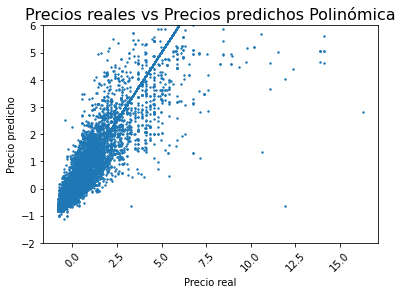

In [709]:
plt.scatter(y_test_reg1,y_test_pred_reg_2, s =2)
plt.plot(y_test_reg1,y_test_reg1)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.ylim((-2.0,6.0))
plt.title("Precios reales vs Precios predichos Polinómica",fontsize=16)
plt.xticks(rotation=45)

Podemos notar ampliamiento como mejoro el modelo al tratar a los datos teniendo en cuenta un grado polinómico =2. No utilice un grado polinómico mayor dada la cantidad de atributos que contiene el data set dado el encoding.

Implementare la **regulación** por Lasso para compararlo con los atributos polinómicos y ver si existe una mejora. Uso la Lasso dado que podré visualizar aquellos atributos que no aporten al modelo dado que tendrán un coeficiente igual a cero (0).

Las estrategias de regularización incorporan penalizaciones en el ajuste por mínimos cuadrados ordinarios con el objetivo de evitar overfitting, reducir varianza, atenuar el efecto de la correlación entre predictores y minimizar la influencia en el modelo de los predictores menos relevantes. 

In [710]:
from sklearn.linear_model import Lasso
reg_lasso = Lasso(alpha = 0.0001) # Explicar hiperparámetro alpha
reg_lasso.fit(X_train_new1,y_train_reg1)
y_train_pred_reg4 = reg_lasso.predict(X_train_new1)
y_test_pred_reg4 = reg_lasso.predict(X_test_new1)

print(reg_lasso.coef_, reg_lasso.intercept_)

[0.03746148 0.11740549 0.24032207 ... 0.16963525 0.         0.03960724] -0.2798589260652805


In [711]:
Train_score2=r2_score(y_train_reg1,y_train_pred_reg4)
Test_score2=r2_score(y_test_reg1,y_test_pred_reg4)

test_score2_r2_ajust_reg = 1-(1-Test_score2)*(len(y_test_reg1)-1)/(len(y_test_reg1)-X_dummies.shape[1]-1)
rmse_train_reg4 = np.sqrt(mean_squared_error(y_train_reg1, y_train_pred_reg4))
rmse_test_reg4 = np.sqrt(mean_squared_error(y_test_reg1, y_test_pred_reg4))

print(Train_score2,Test_score2,test_score2_r2_ajust_reg,rmse_test_reg4)

0.7743646372426207 0.7751511856222717 0.7746378917531176 0.47445068569658616


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

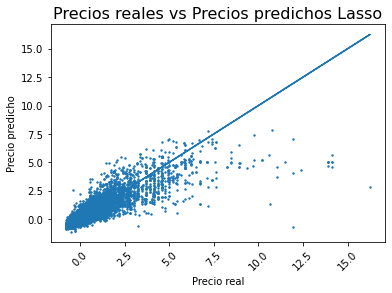

In [712]:
plt.scatter(y_test_reg1,y_test_pred_reg4, s =2)
plt.plot(y_test_reg1,y_test_reg1)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Precios reales vs Precios predichos Lasso",fontsize=16)
plt.xticks(rotation=45)

Mediante la regulación, podemos visualizar una recta distinta a la brindada por el gráfico de polinominización de Grado 2 pero tambíen el modelo pareciera explicar de una mejor manera a los datos que en el mundo de la linealidad.

In [713]:
dicc1={"R2_Train":[train_r2_reg,tree_scores.mean(),Train_score1,Train_score2],"R2_Test":[test_r2_reg,tree_scores.mean(),Test_score1,Test_score2,],"R2_Test_Ajus":[test_r2_ajust_reg,tree_scores.mean(),test_score1_r2_ajust_reg,test_score2_r2_ajust_reg],"Modelos":["Regresión","Regresión con VC","Polinomio:Grado 2","Lasso"]}

In [714]:
resultados2=pd.DataFrame(dicc1)
resultados2

,R2_Train,R2_Test,R2_Test_Ajus,Modelos
0,0.67737,0.68286,0.67663,Regresión
1,0.67358,0.67358,0.67358,Regresión con VC
2,0.77486,0.77530,0.77478,Polinomio:Grado 2
3,0.77436,0.77515,0.77464,Lasso


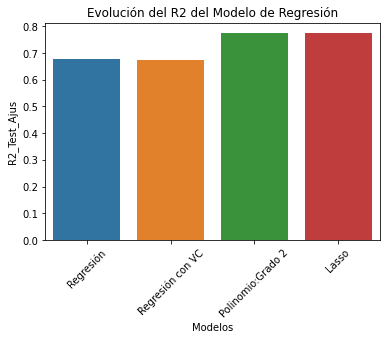

In [715]:
sns.barplot(data=resultados2,x="Modelos", y="R2_Test_Ajus")
plt.xticks(rotation = 45)
plt.title("Evolución del R2 del Modelo de Regresión")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar en este gráfico como a medida que fui optimizando el modelo a través de distintos métodos, fui obteniendo datos mejores.

Proseguiré a analizar la evolución de los errores a medida que fuimos optimizando el modelo. La lógica indica que estos deberían ir disminuyendo.

In [716]:
dicc_error={"RMSE_Train":[rmse_train_reg,rmse_train_reg_2,rmse_train_reg4],"RSME_Test":[rmse_test_reg,rmse_test_reg_2,rmse_test_reg4],"Modelos":["Regresión","Polinomio:Grado 2","Lasso"]}

In [717]:
resultados_error=pd.DataFrame(dicc_error)
resultados_error

,RMSE_Train,RSME_Test,Modelos
0,0.57264,0.55225,Regresión
1,0.47437,0.47430,Polinomio:Grado 2
2,0.47489,0.47445,Lasso


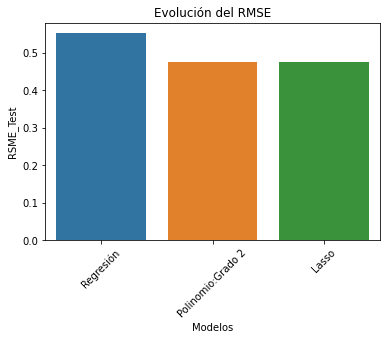

In [718]:
sns.barplot(data=resultados_error,x="Modelos", y="RSME_Test")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como podemos visualizar a medida que vamos mejorando el modelo utilizando distintas técnicas/métodos el error disminuye lo que es lógico.

Como conclusión del Modelo Regresión Lineal si bien en una primera instancia no se adapta bien a los datos, en la medida que se fueron realizando métodos para mejorarlo, tuvo sus mejoras por ejemplo al tratar sus datos con una polinómica de grado=2, o aplicando la regularización mediante Lasso. También pudimos notar como el error disminuyó desde el primer modelo al último.

**Comparación Modelo de árboles vs Modelo de Regresión**

In [721]:
dicc_comp={"R2_Test":[Test_score1,Test_score2,R2_CV_hiper],"Split":["Regresión","Regresión","Árboles"],"Modelos":["Polinomio:Grado 2","Lasso","Con Hiperparámetros"]}

In [722]:
resultados_comp=pd.DataFrame(dicc_comp)
resultados_comp

,R2_Test,Split,Modelos
0,0.77530,Regresión,Polinomio:Grado 2
1,0.77515,Regresión,Lasso
2,0.80657,Árboles,Con Hiperparámetros


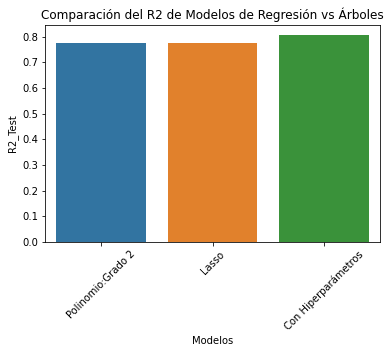

In [723]:
sns.barplot(data=resultados_comp,x="Modelos", y="R2_Test")
plt.xticks(rotation = 45)
plt.title("Comparación del R2 de Modelos de Regresión vs Árboles")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como podemos visualizar es por este otivo que proseguiré con el Modelo de Árboles dado que obtuvo un mejor R2.

Proseguiré a seguir optimizando el modelo de árboles, que fue el modelo que dio un mejor R2. Lo haré utilizando el método de Bagging y también el de Boosting. Entendiendo que el método de Bagging suele ser mejor cuando hay alto error de varianza y el método de Boosting suele implementarse cuando nos encontramos con modelos de alto Sesgo. Dado que en mi problema dichos errores se encuentran equilibrados, proseguiré a probar ambos métodos y eligiré el que de un R2 mayor.

**Bagging**

In [724]:
from sklearn.ensemble import RandomForestRegressor

In [725]:
X_train_reg2, X_test_reg2, y_train_reg2, y_test_reg2 = train_test_split(X_dummies, y_dummies, test_size=0.30)
regr = RandomForestRegressor(n_estimators=150,n_jobs=-1, random_state=42)
regr.fit(X_train_reg2,y_train_reg2)

RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=42)

In [726]:
y_train_pred_reg2 = regr.predict(X_train_reg2)
y_test_pred_reg2 = regr.predict(X_test_reg2)
print("Train:",metrics.r2_score(y_train_reg2, y_train_pred_reg2))
print("Test:",metrics.r2_score(y_test_reg2, y_test_pred_reg2))
print("Train:",metrics.mean_squared_error(y_train_reg2, y_train_pred_reg2))
print("Test:",metrics.mean_squared_error(y_test_reg2, y_test_pred_reg2))

Bagging=metrics.r2_score(y_test_reg2, y_test_pred_reg2)
Bagging_RMSE=metrics.mean_squared_error(y_test_reg2, y_test_pred_reg2)

Train: 0.9272846584811953
Test: 0.8390969691729036
Train: 0.07097958300784364
Test: 0.16983385318934718


Podemos notar que hay una diferencia considerable entre los valores de entrenamiento, por lo que proseguiré a optimizar mi modelo.

**Optimización de Hiperparámetros**

Vamos a realizar la Optimización de hiperparámetros para evitar sobreajustes del modelo dado que vemos una gran diferencia entre los datos de entrenamiento y testeo.

In [727]:
param_grid_bagging = {'criterion':['mse'],
                   'n_estimators' :[100,150,175,200],
              'min_samples_split':np.arange(4, 6),
              'min_samples_leaf':np.arange(2,5)}

In [728]:
regr_bagging = RandomForestRegressor()

In [729]:
#model22 = GridSearchCV(regr_bagging , param_grid=param_grid_bagging,scoring='r2', cv=5)

In [730]:
#model22.fit(X_dummies, y_dummies)

In [317]:
#print("Mejores parametros: "+str(model22.best_params_))
#print("Mejor Score: "+str(model22.best_score_)+'\n')
#Score_hiper_bagging=model22.best_score_
#scores22 = pd.DataFrame(model22.cv_results_)
#scores22

Mejores parametros: {'criterion': 'mse', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 175}
Mejor Score: 0.823622971383869



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,52.58493,3.26034,0.47573,0.02646,mse,2,4,100,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79540,0.85710,0.82673,0.78107,0.85392,0.82285,0.03050,8
1,84.58133,3.18952,0.78730,0.06710,mse,2,4,150,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79540,0.85683,0.82580,0.78362,0.85463,0.82326,0.02988,6
2,97.78972,2.79536,0.84235,0.05781,mse,2,4,175,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79678,0.85694,0.82587,0.78378,0.85474,0.82362,0.02964,1
3,116.35279,1.28527,0.99924,0.07034,mse,2,4,200,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79654,0.85677,0.82580,0.78252,0.85482,0.82329,0.03000,5
4,57.73602,0.30199,0.50625,0.04030,mse,2,5,100,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79677,0.85577,0.82642,0.78275,0.85596,0.82353,0.02993,2
5,84.75587,3.19952,0.71828,0.05209,mse,2,5,150,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79627,0.85654,0.82571,0.78324,0.85366,0.82308,0.02956,7
6,97.80809,5.69823,0.85292,0.09817,mse,2,5,175,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79629,0.85685,0.82524,0.78364,0.85510,0.82342,0.02981,3
7,105.92862,6.69527,0.98138,0.05132,mse,2,5,200,"{'criterion': 'mse', 'min_samples_leaf': 2, 'm...",0.79634,0.85681,0.82582,0.78262,0.85499,0.82332,0.03005,4
8,55.77300,1.19314,0.48650,0.01581,mse,3,4,100,"{'criterion': 'mse', 'min_samples_leaf': 3, 'm...",0.79530,0.85234,0.82291,0.78599,0.84864,0.82104,0.02696,15
9,79.20413,2.54625,0.69174,0.07221,mse,3,4,150,"{'criterion': 'mse', 'min_samples_leaf': 3, 'm...",0.79583,0.85254,0.82335,0.78677,0.84980,0.82166,0.02695,11


El modelo con los hiperparámetros encontrados es:

In [731]:
X_train_reg23, X_test_reg23, y_train_reg23, y_test_reg23 = train_test_split(X_dummies, y_dummies, test_size=0.30)
regr23 = RandomForestRegressor(n_estimators=175,n_jobs=-1,min_samples_leaf=2,min_samples_split=4, random_state=42)
regr23.fit(X_train_reg23,y_train_reg23)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=175,
                      n_jobs=-1, random_state=42)

In [732]:
y_train_pred_reg23 = regr.predict(X_train_reg23)
y_test_pred_reg23 = regr.predict(X_test_reg23)
print("Train:",metrics.r2_score(y_train_reg23, y_train_pred_reg23))
print("Test:",metrics.r2_score(y_test_reg23, y_test_pred_reg23))
Bagging23=metrics.r2_score(y_test_reg23, y_test_pred_reg23)
Bagging23_RMSE=metrics.mean_squared_error(y_test_reg23, y_test_pred_reg23)
print("RMSE:",Bagging23_RMSE)

Train: 0.9045571093653704
Test: 0.8873902647399137
RMSE: 0.11359544061403817


Podemos notar como no solo se redujo la varianza sino que también disminuyó el sesgo.

Eligiré un árbol de los 175 que fueron estimados para ver los Hiper parámetros que contiene.

In [733]:
regr_tree = regr23.estimators_[100]
regr_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2016850622,
 'splitter': 'best'}

Proseguiremos con visualizar cuales son los atributos mas significantes para el modelo.

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


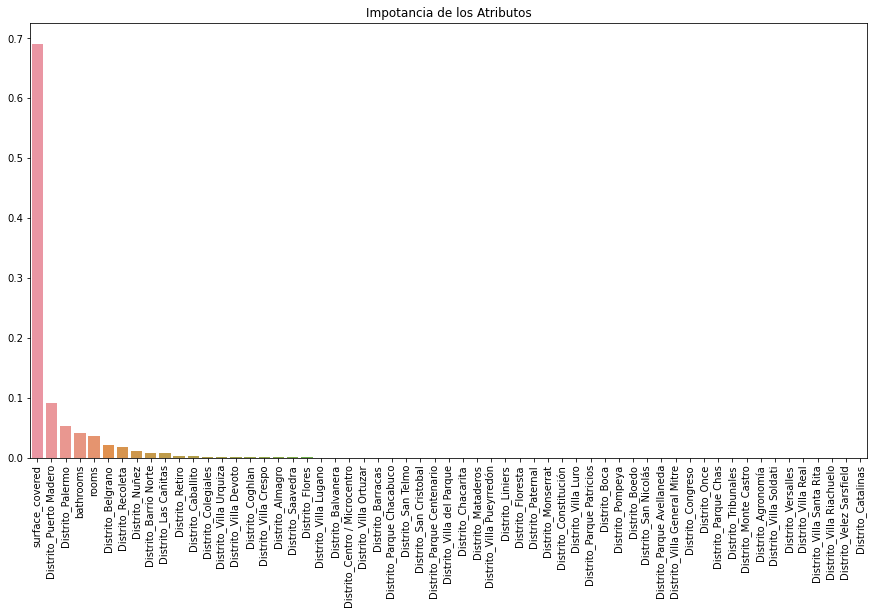

In [734]:
importances = regr23.feature_importances_
columns = X_train_reg23.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.xticks(rotation = 90)
plt.title("Impotancia de los Atributos")
plt.show()

In [735]:
imp=pd.DataFrame(importances,index=columns,columns=['Imp'])
imp.sort_values('Imp',ascending=False)

,Imp
surface_covered,0.69100
Distrito_Puerto Madero,0.09095
Distrito_Palermo,0.05383
bathrooms,0.04136
rooms,0.03555
Distrito_Belgrano,0.02139
Distrito_Recoleta,0.01826
Distrito_Nuñez,0.01151
Distrito_Barrio Norte,0.00822
Distrito_Las Cañitas,0.00765


Voy a analizar que pasa con el modelo cuando selecciono solo aquellos atributos que forman parte de mas del 95% de la Importancia vista en el gráfico anterior.

In [736]:
X_dummies_randomf=data_con_dummies1[['surface_covered','bathrooms','rooms','Distrito_Palermo','Distrito_Puerto Madero','Distrito_Recoleta','Distrito_Belgrano','Distrito_Barrio Norte','Distrito_Las Cañitas','Distrito_Nuñez']]
y_dummies_randomf=data_con_dummies1['price']
# Uso los atributos que me generan más de un 95% de la importancia para ver si mejora el modelo

In [737]:
X_train_reg21, X_test_reg21, y_train_reg21, y_test_reg21 = train_test_split(X_dummies_randomf, y_dummies_randomf, test_size=0.30)
regr21 = RandomForestRegressor(n_estimators=175,n_jobs=-1,min_samples_leaf=2,min_samples_split=4, random_state=42)
regr21.fit(X_train_reg21,y_train_reg21)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=175,
                      n_jobs=-1, random_state=42)

In [738]:
y_train_pred_reg21 = regr21.predict(X_train_reg21)
y_test_pred_reg21 = regr21.predict(X_test_reg21)
print("Train:",metrics.r2_score(y_train_reg21, y_train_pred_reg21))
print("Test:",metrics.r2_score(y_test_reg21, y_test_pred_reg21))
Bagging21=metrics.r2_score(y_test_reg21, y_test_pred_reg21)

Train: 0.8896341450298322
Test: 0.811523522589032


In [739]:
resultados21={"R2":[Bagging,Bagging23,Bagging21],"Modelo":["Bagging","Bagging Optimizado","Bagging con Reducción de Atributos"]}

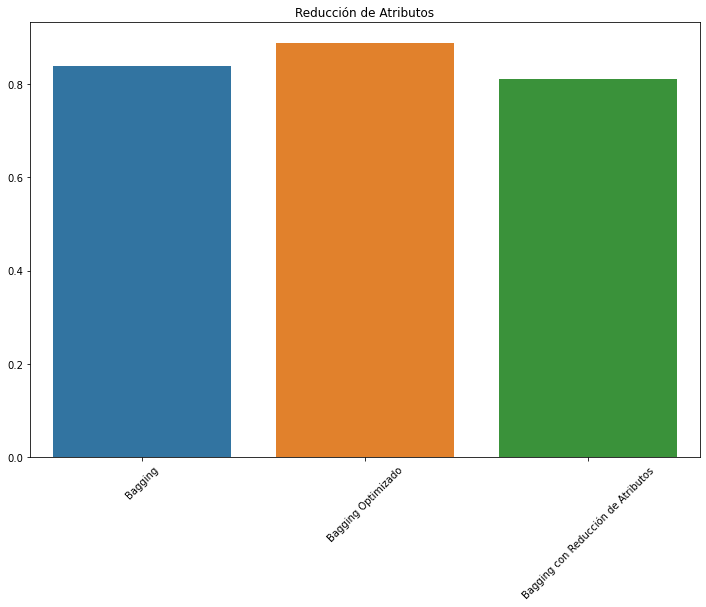

In [740]:
plt.figure(figsize=(12,8))
sns.barplot(data=resultados21,x="Modelo", y="R2")
plt.xticks(rotation = 45)
plt.title("Reducción de Atributos")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar que al reducir los atributos con una poca impotancia comparado a los demás, no mejora el modelo, por lo que hay algo que estan aportando al modelo que hace que de mejor con todos los atributos.

También se puede visualizar claramente como la optimización de hiperparámetros mejoró ampliamiente el modelo logrando un R2 de 90%.

**Boosting**

In [741]:
from sklearn.ensemble import AdaBoostRegressor
regr3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=19), n_estimators=150)
regr3.fit(X_train_reg2,y_train_reg2)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=19),
                  n_estimators=150)

In [742]:
y_train_pred_reg3 = regr3.predict(X_train_reg2)
y_test_pred_reg3 = regr3.predict(X_test_reg2)
print("Train:",metrics.r2_score(y_train_reg2, y_train_pred_reg3))
print("Test:",metrics.r2_score(y_test_reg2, y_test_pred_reg3))
Boosting=metrics.r2_score(y_test_reg2, y_test_pred_reg3)

Train: 0.8839237041500316
Test: 0.7985947484105393


Analizaré la importancia de los atributos.

In [743]:
regr3.feature_importances_

array([4.88076179e-02, 4.24906806e-02, 6.00922730e-01, 2.53642274e-05,
       2.51853096e-04, 9.28428954e-05, 5.56668500e-05, 4.84666857e-03,
       1.39295049e-02, 4.39868350e-05, 1.69695061e-05, 1.17829090e-03,
       0.00000000e+00, 5.14883594e-04, 5.01824344e-05, 5.66707477e-04,
       6.89865991e-04, 3.68218587e-06, 2.04170908e-05, 6.41762629e-05,
       3.26369612e-05, 3.87110662e-03, 3.78919521e-05, 5.44693613e-05,
       9.44363914e-06, 2.72407725e-06, 5.33613857e-03, 9.38462085e-06,
       6.73683372e-02, 3.45171173e-06, 6.95614188e-05, 3.00383799e-04,
       4.67068362e-06, 6.44017555e-05, 2.63062840e-05, 3.12408112e-05,
       4.67178074e-02, 9.30062070e-03, 2.25833125e-03, 9.44587307e-05,
       1.47747379e-01, 1.28787143e-05, 1.08519811e-05, 5.38983799e-06,
       4.88062461e-08, 4.75753086e-08, 2.23623069e-04, 5.13442735e-04,
       9.76419039e-06, 1.16955455e-04, 1.64981344e-05, 3.69531978e-04,
       5.08547900e-05, 0.00000000e+00, 5.31473944e-08, 1.07522409e-06,
      

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


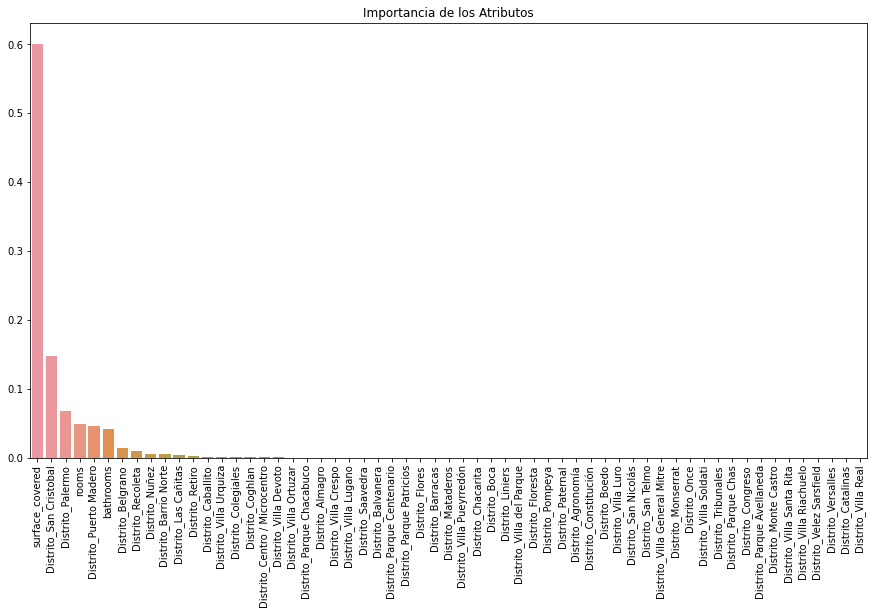

In [744]:
importances = regr3.feature_importances_
columns = X_train_reg2.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.xticks(rotation = 90)
plt.title("Importancia de los Atributos")
plt.show()

Podemos visualizar como las variables "Superficie Cubierta" y algunos distritos son las mas relevantes de todas con gran diferencia.

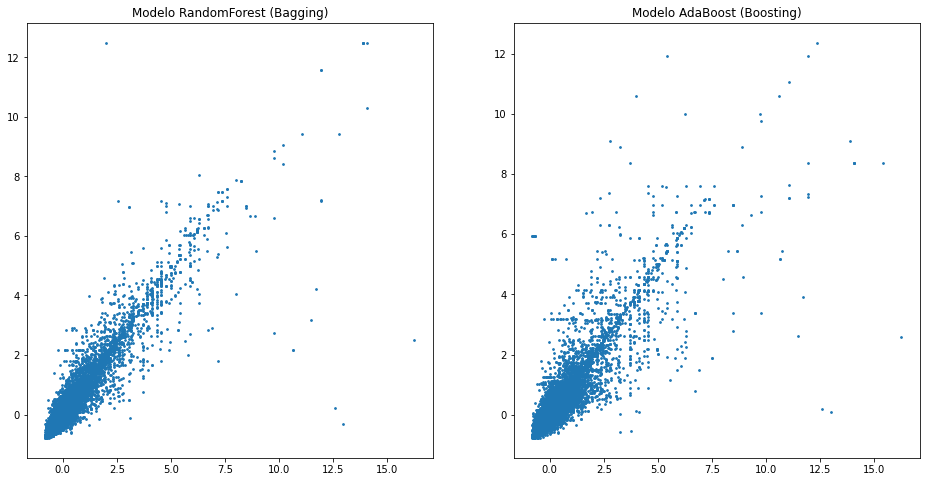

In [745]:
fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(16,8))
ax1.scatter(y_test_reg23,y_test_pred_reg23,s=3)
ax1.set_title("Modelo RandomForest (Bagging)")
ax2.set_title("Modelo AdaBoost (Boosting)")
ax2.scatter(y_test_reg2,y_test_pred_reg3,s=3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [746]:
resultados13={"R2":[R2_train0,R2_train1,R2_train2,R2_test0,R2_test1,R2_test2,R2_CV,R2_CV_hiper,Bagging,Bagging23,Boosting],"Split":["Train","Train","Train","Test","Test","Test","CV","Hiperparámetros","Bagging","Bagging Optimizado","Boosting"],"Modelo":["Sin Escalado","Con Escalado","Con Escalado y Dummies","Sin Escalado","Con Escalado","Con Escalado y Dummies","Validación Cruzada","Con Hiperparámetros","Bagging","Bagging Optimizado","Boosting"]}

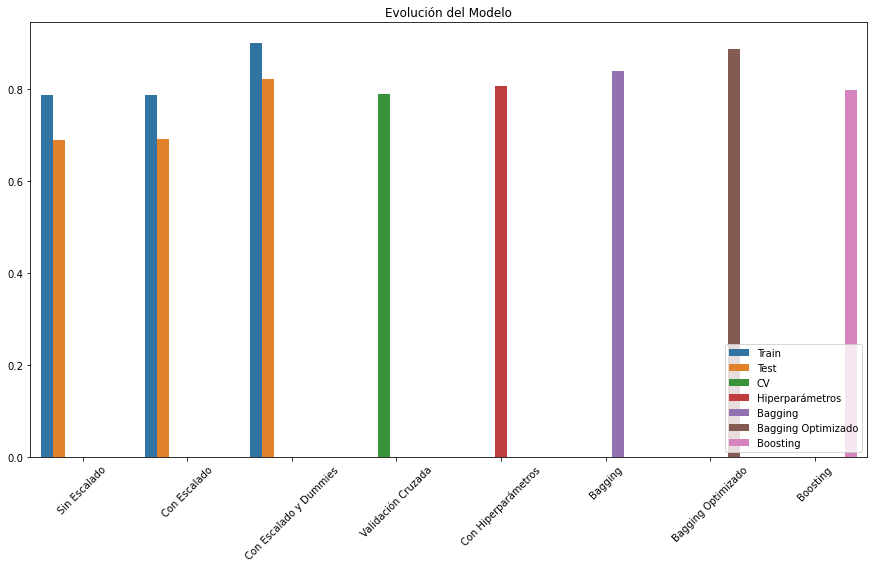

In [747]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados13,x="Modelo", y="R2",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del Modelo")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como bien podemos visualizar en el gráfico, eligiría el Modelo de RandomForest, realizando la técnica de Bagging optimizado por los HiperParámetros dado que es el modelo que mejor R2 tiene de un 90%.

In [750]:
resultados_RMSE21={"RMSE":[rmse_train1,rmse_train2,rmse_test1,rmse_test2,RSME_CV,RSME_CV_hiper,Bagging_RMSE,Bagging23_RMSE],"Split":["Train","Train","Test","Test","CV","Hiperparámetros","Bagging","Bagging Optimizado"],"Modelo":["Con Escalado","Con Escalado y Dummies","Con Escalado","Con Escalado y Dummies","Validación Cruzada","Con Hiperparámetros","Bagging","Bagging Optimizado"]}

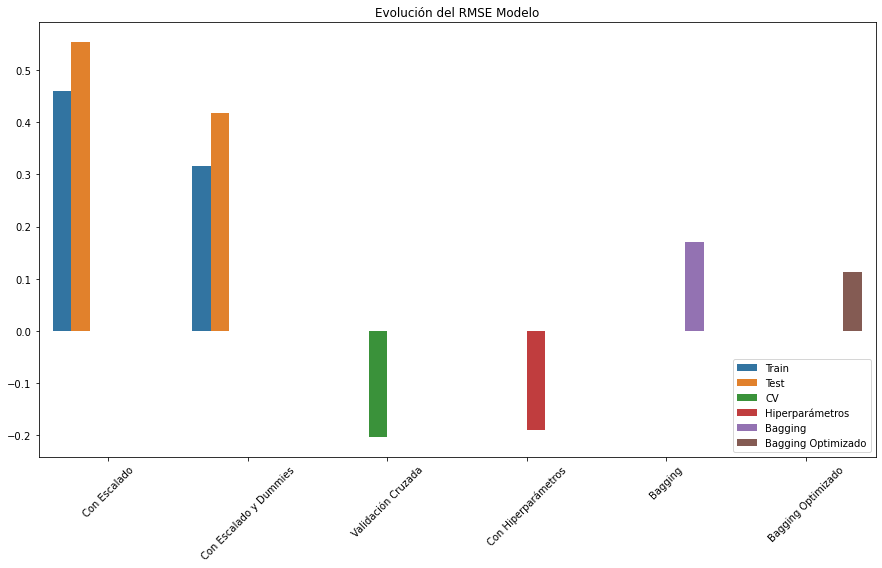

In [751]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE21,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Como bien podemos visualizar en el gráfico, el error fue disminuyendo a medida que fui optimizando mi modelo llegando a un error cuadrático medio de aproximado 0.1. Si bien esta normalizado y no es un valor representativo como bien lo he explicado anteriormente, podemos visualizar como a medida que fui optimizando el modelo, el error cuadrático medio fue disminuyendo.

Como consluión final del proyecto, puedo decir que para mejorar el modelo uno tiene que ir analizando distintos métodos de optimización de modelos, y distintos modelos para ir comparando aquellos modelos o métodos a los cuales se pueda adaptar el Data Set.
**Modelos**: Árboles, Regresión o modelos avanzados de Ensamble como Random Forest con la técnica de Bagging o el AdaBoost como técnica de Boosting.
**Métodos**: Preprocesamiento de Datos (Outliers, Imputación de Datos, Escalado de Datos, Encoding de atributos categóricos), optimización de modelos como analizar HiperParámetros, validación cruzada, reglularización y atributos polinómicos dependiendo del Modelo utilizado.
Se lo puede ir mejorando optimizando dichos métodos/modelos al máximo disminuyendo la varianza y el sesgo. Estos son dos errores que se encontraron a lo largo de mis Modelos, pero a medida que fui optimizandolos, dichos errores fueron disminuyendo con respecto al primer modelo.

Como mejora al último modelo realizado, puedo decir que se lo podría mejorar si por ejemplo se agrega la variable de transportes públicos por la Zona. En Argentina, esta muy bien visto que tranporte público se encuentra cerca de la propiedad, por lo que se me ocurre que sería una variable interesante al incluirla al análisis.

## Proyecto Final

En dicho Proyecto buscare aplicar un nuevo modelo de Machine Learning investigando para ver no solo si se puede mejorar la metrica sino tambien analizar su interpretabilidad. 

Con el nuevo modelo de machine learning aplicado a la cotizacion buscare mejorar el modelo tanto en metrica o en interpretabilidad o tambien en asegurarme de utilizar modelos mas robustos que me den una metrica significante.Buscare investigar distintos modelos que no hemos aprendido en clase para validar como se adapta el dataset a cada modelo y poder evaluar sus distintas metricas.

In [378]:
data_ml_original.head()

,start_date,end_date,created_on,lat,lon,País,Zona,Distrito,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.60588,-58.38495,Argentina,Capital Federal,San Cristobal,7.00000,7.00000,2.00000,140.00000,140.00000,153000.00000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.62406,-58.41211,Argentina,Capital Federal,Boedo,2.00000,1.00000,2.00000,70.00000,58.00000,159000.00000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.59357,-58.42747,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,45.00000,45.00000,125000.00000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.58129,-58.43675,Argentina,Capital Federal,Palermo,2.00000,1.00000,1.00000,85.00000,50.00000,295000.00000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.91419,-57.93822,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.00000,1.00000,1.00000,50.00000,35.00000,40000.00000,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [236]:
data_con_dummies1.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Distrito_Agronomía,Distrito_Almagro,Distrito_Balvanera,Distrito_Barracas,...,Distrito_Villa Lugano,Distrito_Villa Luro,Distrito_Villa Ortuzar,Distrito_Villa Pueyrredón,Distrito_Villa Real,Distrito_Villa Riachuelo,Distrito_Villa Santa Rita,Distrito_Villa Soldati,Distrito_Villa Urquiza,Distrito_Villa del Parque
0,3.46693,5.07560,0.58927,0.82962,1.33806,-0.40223,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.81450,-0.95113,0.58927,-0.35421,-0.44455,-0.37624,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.81450,-0.95113,-0.68048,-0.77700,-0.72716,-0.52351,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.81450,-0.95113,-0.68048,-0.10053,-0.61846,0.21283,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.81450,-0.95113,-0.68048,-0.59097,-0.48803,-0.41523,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
X_train_reg_pf, X_test_reg_pf, y_train_reg_pf, y_test_reg_pf = train_test_split(X_dummies, y_dummies, test_size=0.20)

Como podemos notar en los resultados estamos obteniendo metricas significativas con modelos mas robustos, que contemplan varios modelos por separados y los ensambla obteniendo un resultado final tal como esperaba.

**Elastic Net**

Una extensión de la regresión lineal implica penalizar a la función de pérdida durante el entrenamiento que fomentan modelos más simples que tienen valores de coeficientes más pequeños. Estas extensiones se conocen como regresión lineal regularizada o regresión lineal penalizada. La red elástica es un tipo popular de regresión lineal regularizada que combina dos penalizaciones populares, específicamente las funciones de penalización L1 y L2.

In [388]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
reg_pf1 = ElasticNet(alpha = 0.0000005, l1_ratio = 0.9,random_state=0)
reg_pf1.fit(X_train_reg_pf,y_train_reg_pf)

ElasticNet(alpha=5e-07, l1_ratio=0.9, random_state=0)

In [389]:
y_train_pred_reg_pf1 = reg_pf1.predict(X_train_reg_pf)
y_test_pred_reg_pf1 = reg_pf1.predict(X_test_reg_pf)
print("Train:",metrics.r2_score(y_train_reg_pf, y_train_pred_reg_pf1))
print("Test:",metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf1))
Elastic_pf=metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf1)

Train: 0.6789739251130751
Test: 0.6790362022369633


In [390]:
Elastic_pf_RMSE=metrics.mean_squared_error(y_test_reg_pf, y_test_pred_reg_pf1)
print("RMSE:",Elastic_pf_RMSE)

RMSE: 0.32952131188683703


In [752]:
resultados_RMSE23={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE],"Split":["Bagging Optimizado","Elastic Net"],"Modelo":["Bagging Optimizado","Elastic Net"]}

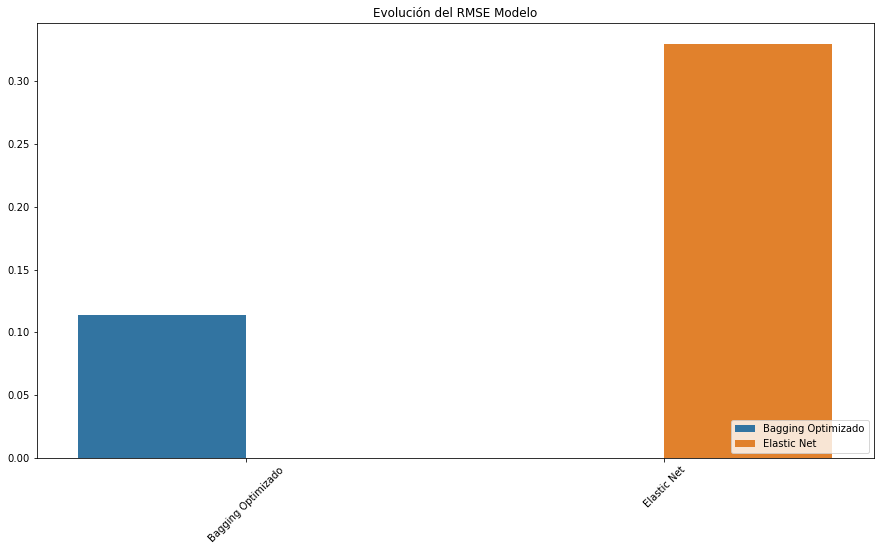

In [753]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE23,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar como este modelo, esta lejos del resultado del Proyecto 2 tanto en RMSE como en R2.

**Gradient Boosting Regressor**

Este modelo constuye un modelo adicional de manera progresiva en etapas. Permite la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa se ajusta un árbol de regresión sobre el gradiente negativo de la función de pérdida dada, de este manera poder lograr el mejor modelo con el resultado con menos perdida.

In [401]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
reg_pf2 = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 10, loss = 'huber')
reg_pf2.fit(X_train_reg_pf,y_train_reg_pf)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000)

In [402]:
y_train_pred_reg_pf2 = reg_pf2.predict(X_train_reg_pf)
y_test_pred_reg_pf2= reg_pf2.predict(X_test_reg_pf)
print("Train:",metrics.r2_score(y_train_reg_pf, y_train_pred_reg_pf2))
print("Test:",metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf2))
Gradient_pf=metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf2)

Train: 0.8131884933720911
Test: 0.8066664784248772


In [403]:
Gradient_pf_RMSE=metrics.mean_squared_error(y_test_reg_pf, y_test_pred_reg_pf2)
print("RMSE:",Gradient_pf_RMSE)

RMSE: 0.19848816628276256


In [754]:
resultados_RMSE24={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE,Gradient_pf_RMSE],"Split":["Bagging Optimizado","Elastic Net","Gradient Boosting"],"Modelo":["Bagging Optimizado","Elastic Net","Gradient Boosting"]}

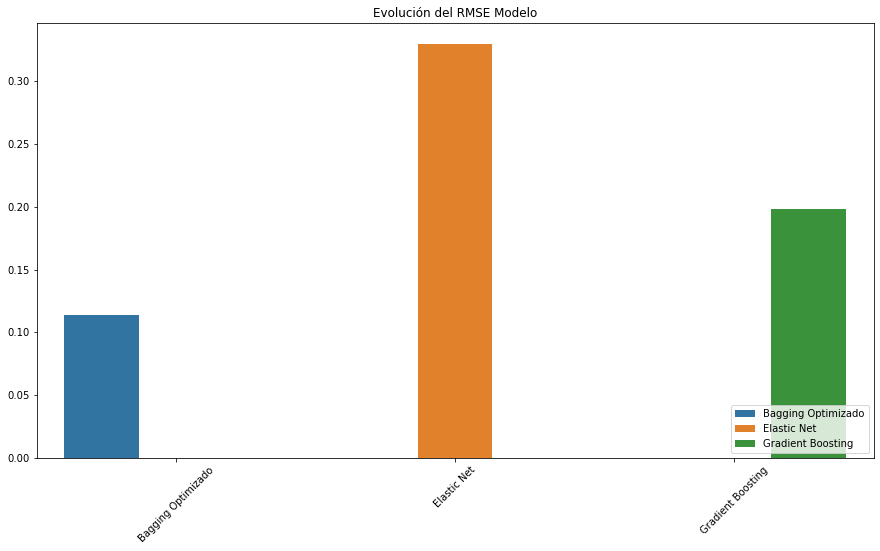

In [755]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE24,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar como obtuvimos un mejor resultado que el Modelo anterior, pero aun esta un poco alejado del Resultado que espero por lo que seguire probando otros modelos.

**Keras**

Keras es una API de aprendizaje profundo escrita en Python, que se ejecuta sobre la plataforma de aprendizaje automático TensorFlow

Las estructuras de datos centrales de Keras son capas y modelos . El tipo de modelo más simple es el Sequential, una pila lineal de capas.

In [234]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf

Voy a agregarle una capa Dense

In [312]:
model = tf.keras.models.Sequential()
model.add(Dense(13, input_dim=30, kernel_initializer='normal', activation='relu'))

El error logarítmico cuadrático medio (MSLE) se puede interpretar como una medida de la relación entre los valores verdaderos y predichos

El error logarítmico cuadrático medio es una variación del error cuadrático medio 

La introducción del logaritmo hace que MSLE solo se preocupe por la diferencia relativa entre el valor verdadero y el predicho

In [313]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_logarithmic_error'])

In [316]:
model.fit(X_train_reg_pf,y_train_reg_pf,epochs=10,batch_size=128)

Epoch 1/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3827 - mean_squared_logarithmic_error: 0.0319
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3824 - mean_squared_logarithmic_error: 0.0319
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3821 - mean_squared_logarithmic_error: 0.0319
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3821 - mean_squared_logarithmic_error: 0.0319
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3819 - mean_squared_logarithmic_error: 0.0319
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3816 - mean_squared_logarithmic_error: 0.0320
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3814 - mean_squared_logarithmic_error: 0.0320
Epoch 8/10
540/540 [==============================] - 1s 2ms/step - loss: 0.3812 - mean_squared_logarithmic_error: 0.0319
Epoch 9/10
540/540 [====

In [411]:
scores = model.evaluate(X_train_reg_pf,y_train_reg_pf,batch_size=128)
print("\n%s: %.2f" % (model.metrics_names[0], scores[0]))

540/540 [==============================] - 1s 2ms/step - loss: 0.3805 - mean_squared_logarithmic_error: 0.0319

loss: 0.38


Este resultado implica que hay una diferencia de un valor de 3,19% entre los valores predichos y los valores reales. Si bien el error cuadratico medio da del 0.38 cuando en Bagging o en otros modelos como Stacking da un 0.2 el modelo es mas robusto que los demas, por lo que he decidio utilizarlo y evaluar el dataset en dicho modelo.

In [756]:
resultados_RMSE25={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE,Gradient_pf_RMSE,scores[0]],"Split":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras"],"Modelo":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras"]}

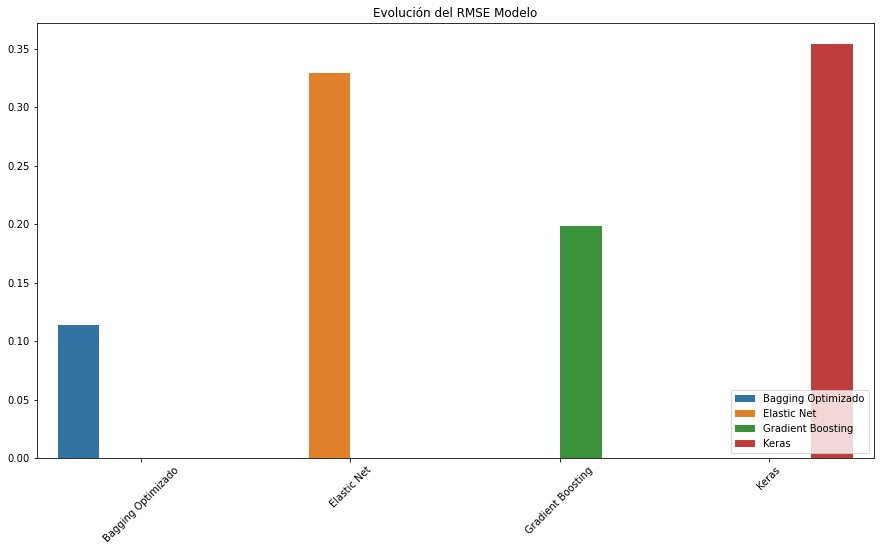

In [757]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE25,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=4)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar como si bien Keras es un modelo de deep learning, no se ha ajustado tal como lo he esperado. Por lo que optare por un modelo de Stacking como prueba. Estos modelos pueden ensamblar varios modelos y asi utilizando las buenas cosas de cada uno poder dar un resultado final, dada la combincacion de modelos.

**Stacking**

Se basa en el concepto de la generalización apilada en donde busca apilar la salida del estimador individual y usar un regresor para calcular la predicción final.

Combina las predicciones de varios modelos construidos con un aprendizaje determinado algoritmo con el fin de mejorar la robustez sobre un solo modelo. Al combinar lo mejor de múltiples algoritmos que pueden dar predicciones más estables con muy poca varianza que lo que obtenemos con un solo regresor.

En este caso probare en apilar el Ridge CV con un modelo Lineal de SVR, modelo de soportes lineales.

In [414]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
estimators2 = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42, tol=1e-05))]
reg_pf = StackingRegressor(estimators=estimators2,final_estimator= RandomForestRegressor(n_estimators=175,n_jobs=-1,min_samples_leaf=2,min_samples_split=4, random_state=42))

In [415]:
reg_pf.fit(X_train_reg_pf,y_train_reg_pf)

C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pc\Data Science\envs\datascience\lib\site-packages\sklearn\svm\_base.py:985

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('svr', LinearSVR(random_state=42, tol=1e-05))],
                  final_estimator=RandomForestRegressor(min_samples_leaf=2,
                                                        min_samples_split=4,
                                                        n_estimators=175,
                                                        n_jobs=-1,
                                                        random_state=42))

In [758]:
y_train_pred_reg_pf = reg_pf.predict(X_train_reg_pf)
y_test_pred_reg_pf = reg_pf.predict(X_test_reg_pf)
print("Train:",metrics.r2_score(y_train_reg_pf, y_train_pred_reg_pf))
print("Test:",metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf))
Stacking_pf=metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf)

Train: 0.7929872380379114
Test: 0.7685060370321111


In [759]:
Stacking_pf_RMSE=metrics.mean_squared_error(y_test_reg_pf, y_test_pred_reg_pf)
print("RMSE:",Stacking_pf_RMSE)

RMSE: 0.23766603867075303


In [760]:
resultados_RMSE26={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE,Gradient_pf_RMSE,scores[0],Stacking_pf_RMSE],"Split":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking"],"Modelo":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking"]}

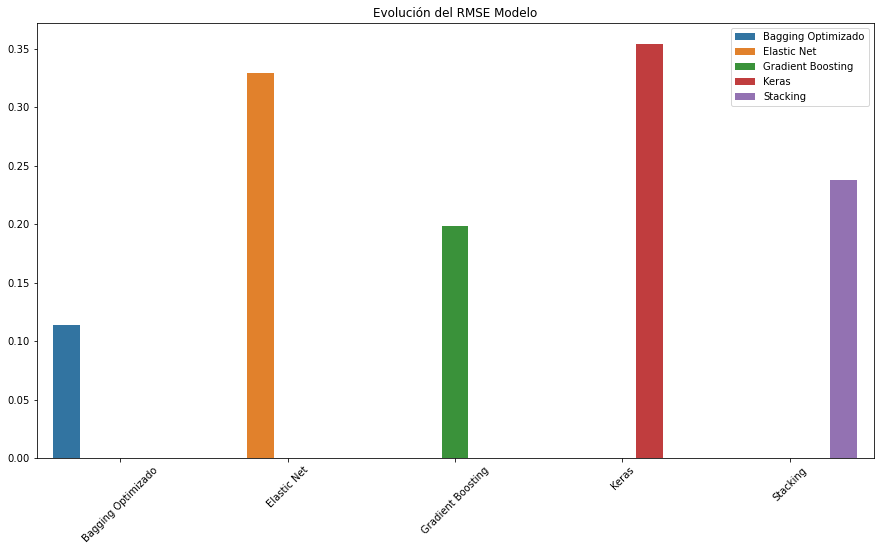

In [761]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE26,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=1)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos notar que comparandolo con el Modelo de Proyecto II no estamos teniendo mejores resultados, por lo que probare en combinar otros modelos.

Probare utilizando un modelo de Gradient Boosting, un modelo de Regresion Lineal, Lasso y por ultimo el Modelo de Random Forest.

In [420]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [421]:
stacking_regressor.fit(X_train_reg_pf,y_train_reg_pf)

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(n_estimators=400,
                                                     random_state=0)),
                              ('Lasso', Lasso(alpha=0.005, random_state=0)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=4,
                                                         min_samples_split=5,
                                                         n_estimators=500))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [422]:
y_train_pred_reg_pf2 = stacking_regressor.predict(X_train_reg_pf)
y_test_pred_reg_pf2 = stacking_regressor.predict(X_test_reg_pf)
print("Train:",metrics.r2_score(y_train_reg_pf, y_train_pred_reg_pf2))
print("Test:",metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf2))
Stacking_pf=metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf2)

Train: 0.9082377960852531
Test: 0.8564296351165308


In [423]:
Stacking_pf_RMSE2=metrics.mean_squared_error(y_test_reg_pf, y_test_pred_reg_pf2)
print("RMSE:",Stacking_pf_RMSE2)

RMSE: 0.1473982278194521


In [762]:
resultados_RMSE27={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE,Gradient_pf_RMSE,scores[0],Stacking_pf_RMSE,Stacking_pf_RMSE2],"Split":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking","Stacking Optimizado"],"Modelo":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking","Stacking Optimizado"]}

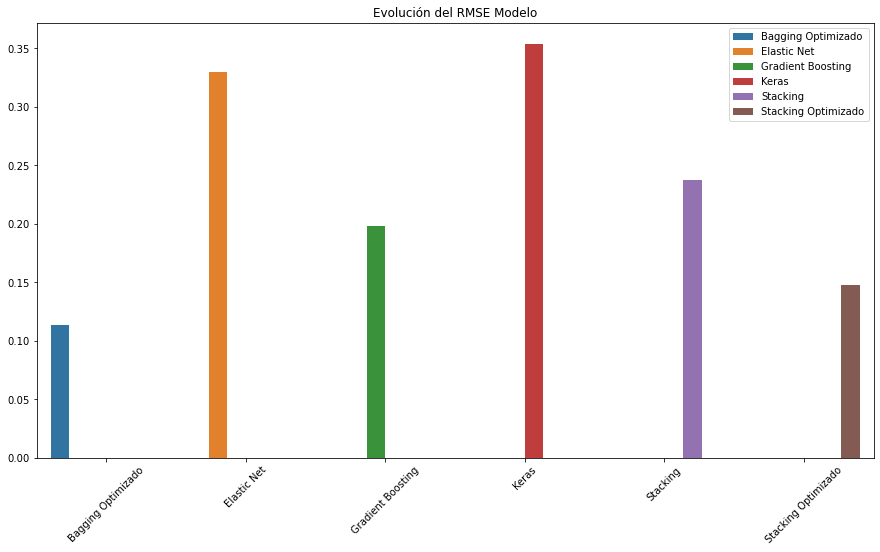

In [763]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE27,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=1)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos ver como con el ultimo modelo de stacking se asemeja mucho al model optimizado del Proyecto II pero con un modelo mas robusto en donde fue una combinacion de distintos modelos y se obtuvo un resultado Final. Si bien en cuanto a metrica no pude mejorar el modelo lorado en el Proyecto II, puedo decir que este modelo es mas robusto a la hora de elegir un modelo.

In [427]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
Elastic =ElasticNet(alpha = 0.0000005, l1_ratio = 0.9,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model),
              ('Elastic Net',Elastic)]
#Stack these models with StackingRegressor
stacking_regressor2 = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [428]:
stacking_regressor2.fit(X_train_reg_pf,y_train_reg_pf)

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(n_estimators=400,
                                                     random_state=0)),
                              ('Lasso', Lasso(alpha=0.005, random_state=0)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=4,
                                                         min_samples_split=5,
                                                         n_estimators=500)),
                              ('Elastic Net',
                               ElasticNet(alpha=5e-07, l1_ratio=0.9,
                                          random_state=0))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [429]:
y_train_pred_reg_pf3 = stacking_regressor2.predict(X_train_reg_pf)
y_test_pred_reg_pf3 = stacking_regressor2.predict(X_test_reg_pf)
print("Train:",metrics.r2_score(y_train_reg_pf, y_train_pred_reg_pf3))
print("Test:",metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf3))
Stacking_pf2=metrics.r2_score(y_test_reg_pf, y_test_pred_reg_pf3)

Train: 0.9071714923691149
Test: 0.8561951768444062


In [430]:
Stacking_pf_RMSE3=metrics.mean_squared_error(y_test_reg_pf, y_test_pred_reg_pf3)
print("RMSE:",Stacking_pf_RMSE3)

RMSE: 0.1476389372014812


In [764]:
resultados_RMSE28={"RMSE":[Bagging23_RMSE,Elastic_pf_RMSE,Gradient_pf_RMSE,scores[0],Stacking_pf_RMSE,Stacking_pf_RMSE2,Stacking_pf_RMSE3],"Split":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking","Stacking Optimizado","Stacking Optimizado v2"],"Modelo":["Bagging Optimizado","Elastic Net","Gradient Boosting","Keras","Stacking","Stacking Optimizado","Stacking Optimizado v2"]}

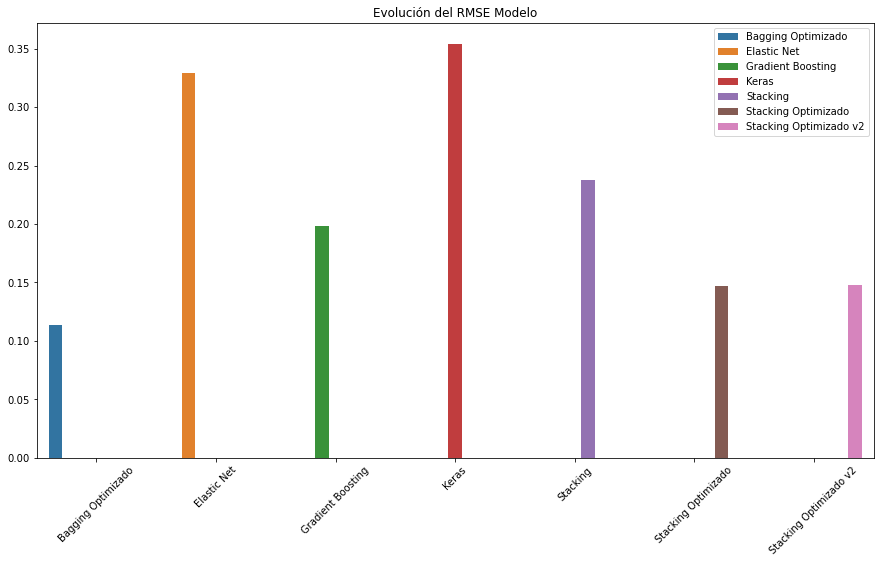

In [765]:
plt.figure(figsize=(15,8))
sns.barplot(data=resultados_RMSE28,x="Modelo", y="RMSE",hue="Split")
plt.xticks(rotation = 45)
plt.title("Evolución del RMSE Modelo")
plt.legend(loc=1)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Podemos visualizar que el ultimo modelo si bien es similiar al anterorio tiene un Error cuadratico medio similar pero levemente superior.

Como conclusion del Proyecto Final y del Curso que puedo tomar es que los Modelos siempre tienen posibilidad de mejora, de hacerlos mas robustos, de mejorar la interpretabilidad de los resultados. Es cuestion de iterar de tener una metodologia de pasos a realizar pero siempre teniendo en cuenta que los modelos se iteran y se mejoran. Tambien tengo claro que la exploracion de datos es tan fundamental como el propio modelo, dado que es muy importante entender el dataset para poder darle interpretabilidad al modelo y analizar los resultados del modelo de otra manera.

En el Proyecto Final decidi inclinarme por seguir investigando sobre otros modelos que me puedan dar mas seguridad, mas robustez, y reafirmar el gran resultado que habia obtenido en el Proyecto II como para demostrar la robustez del Modelo.

Probe varios modelos por separado, note que los resultados no eran como los que esperaba y decidi ir por un modelo en donde pueda combinar varios modelos y llegar a un resultado mas robusto, que fue tal como esperaba un resultado similar al Modelo optimizado del Proyecto 2. Por dicho motivo creo que fue util la investigacion de mi Proyecto Final logrando muy buenos resultados y validando las metricas a las que llegue en el Proyecto II.